# 04_OHT_mooring

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units


import shapely
from shapely.geometry import Point
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# sys.path.append('../Libraries_functions/')
# from LIB_ASI_SIC_UniB import grab_ASI_SIC

# from LIB_geo_plot import *
# # from LIB_access_ERA5 import shift_bylons
# from LIB_PPdrift_NSIDC0116 import grab_icedrift_range

# path to own functions
sys.path.append('../../')
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import geofunc.vectors as vectors
import data_unibremen.SIC as UNISIC
import data_osisaf.icedrift_lr as osidrift
import timeseries.adjust as tseries
import timeseries.analyze as tanalyze
import geofunc.vectors as vectors


### Import data

In [2]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

In [211]:
#===============================================================

# 2016-2017
time_range = slice(datetime(2016, 11, 1), datetime(2017, 5, 30,23))
time_range2 = slice(datetime(2016, 12, 1), datetime(2017, 4, 30,23))

# 2017-2018
time_range = slice(datetime(2017, 11, 1), datetime(2018, 5, 30,23))
time_range2 = slice(datetime(2017, 12, 1), datetime(2018, 4, 30,23))

# 2018-2019
# time_range = slice(datetime(2018, 12, 1), datetime(2019, 2, 10,23))

#===============================================================

#=============
mooring = 'M1'
#=============

open_years = f'{time_range.start.year}_{time_range.stop.year}'

# ocean velocity
#-----------------
dsc = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
dsc.close()
dsc = dsc.sel(time=time_range)
dsc['se'] = vectors.comp_along_theta(dsc.u, dsc.v, 145*units('deg'))
# dsc['nw'] = vectors.comp_along_theta(dsc.u, dsc.v, (145+90)*units('deg'))
# dsc = dsc.interpolate_na(dim='time', method='linear', max_gap='24H', use_coordinate=True)

# ocean temperature, sailinity
#-----------------------------
dso = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_tempsalinity_{open_years}.nc")
dso.close()
dso = dso.sel(time=time_range)
dso['dT'] = dso.Ct - dso.Tf
# dso = dso.interpolate_na(dim='time', method='linear', max_gap='24H', use_coordinate=True)

# sea ice velocity
#------------------
dsi = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_seaice_velocity_{open_years}.nc")
dsi.close()
dsi = dsi.sel(time=time_range)
dsi['se'] = vectors.comp_along_theta(dsi.u, dsi.v, 145*units('deg'))

# ---------- add ice velocity in as surface velocity ----------
# dsc = xr.concat([dsc, dsi], dim='depth')

# ----------------- initial pass to interpolate across time, depth gaps ------------------
og_data = [dso.copy(deep=True), dsc.copy(deep=True), dsi.copy(deep=True)]

for i, ds in enumerate(og_data):
    ds = ds.interpolate_na(dim='time', method='linear', max_gap='24H', use_coordinate=True)
    ds = ds.interpolate_na(dim='depth', method='linear')
    og_data[i] = ds

dso, dsc, dsi = og_data    


## Approaches for extrapolating velocity data

#### (1) val_ext: extrapolate nearest surface/bottom values to bounds
#### (2) lin_ext: interpolate between nearest surface value and ice velocity, interpolate nearest-to-bottom value to zero at bottom
#### (3) shr_ext: extrapolate bulk mean velocity shear between 15-10 m between 10 m and the surface, extrapolate bulk mean velocity shear between 25-30 m between 30 m and the bottom. 

In [212]:
# ---------- interpolate to standard depth intervals ----------
d_depth = np.arange(-40,0+1, 1)

dsc_i = dsc.copy(deep=True).interp(depth = d_depth)

# extrapolate values to the surface
dsc_i['u_val_ext'] = dsc_i['u'].interpolate_na(dim='depth', method='nearest',  fill_value = "extrapolate")
dsc_i['v_val_ext'] = dsc_i['v'].interpolate_na(dim='depth', method='nearest',  fill_value = "extrapolate")
dsc_i['se_val_ext'] = vectors.comp_along_theta(dsc_i['u_val_ext'], dsc_i['v_val_ext'], 145*units('deg'))

In [213]:

dsc_i['u_ice_ext'] = dsc_i['u'].copy(deep=True)
dsc_i['v_ice_ext'] = dsc_i['v'].copy(deep=True)

dsc_i['u_ice_ext'].loc[dict(depth=0)] = dsc_i['u_ice_ext'].sel(depth=0).fillna(dsi.u.sel(depth=0))
dsc_i['v_ice_ext'].loc[dict(depth=0)] = dsc_i['v_ice_ext'].sel(depth=0).fillna(dsi.v.sel(depth=0))

dsc_i['u_ice_ext'] = dsc_i['u_ice_ext'].interpolate_na(dim='depth', method='linear')
dsc_i['v_ice_ext'] = dsc_i['v_ice_ext'].interpolate_na(dim='depth', method='linear')

dsc_i['u_ice_ext'] = dsc_i['u_ice_ext'].interpolate_na(dim='depth', method='nearest',  fill_value = "extrapolate")
dsc_i['v_ice_ext'] = dsc_i['v_ice_ext'].interpolate_na(dim='depth', method='nearest',  fill_value = "extrapolate")

# dsc_i['se_lin_ext'] = vectors.comp_along_theta(dsc_i['u_lin_ext'], dsc_i['v_lin_ext'], 145*units('deg'))


dsc_i['se_ice_ext'] = vectors.comp_along_theta(dsc_i['u_ice_ext'], dsc_i['v_ice_ext'], 145*units('deg'))

<IPython.core.display.Javascript object>


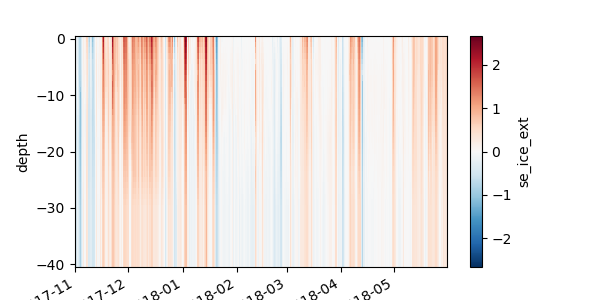

In [214]:
fig, axs = plt.subplots(figsize=(6,3))

dsc_i['se_ice_ext'].plot()

<IPython.core.display.Javascript object>


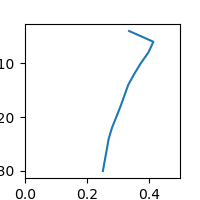

In [215]:
fig, axs = plt.subplots(figsize=(2,2))

plt.xlim(0,0.5)
np.sqrt(dsc.u**2+dsc.v**2).mean('time').plot(y='depth')


<IPython.core.display.Javascript object>


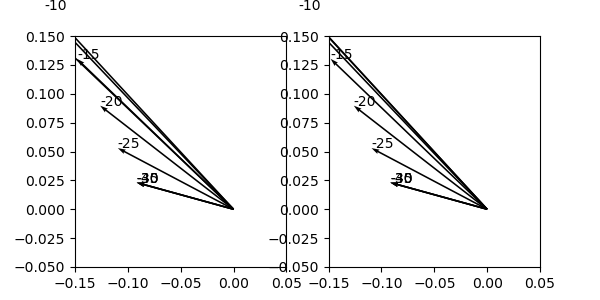

In [216]:
fig, axs = plt.subplots(1,2, figsize=(6,3))

for ax in axs:
    ax.set_xlim(-0.15,0.05)
    ax.set_ylim(-0.05,0.15)

for depth in dsc_i.depth.values[::5]:
    
    
    axs[0].quiver(np.array([0]), np.array([0]), 
               dsc_i.u_ice_ext.sel(depth=depth).mean('time'), 
               dsc_i.v_ice_ext.sel(depth=depth).mean('time'), scale=1, angles='xy', scale_units='xy')
    
    axs[0].text(dsc_i.u_ice_ext.sel(depth=depth).mean('time'), 
               dsc_i.v_ice_ext.sel(depth=depth).mean('time'), depth)
    
    
    axs[1].quiver(np.array([0]), np.array([0]), 
               dsc_i.u_val_ext.sel(depth=depth).mean('time'), 
               dsc_i.v_val_ext.sel(depth=depth).mean('time'), scale=1, angles='xy', scale_units='xy')
    
    axs[1].text(dsc_i.u_val_ext.sel(depth=depth).mean('time'), 
               dsc_i.v_val_ext.sel(depth=depth).mean('time'), depth)

In [217]:
event_times = dsc.se.mean('depth') > 0.25

<IPython.core.display.Javascript object>


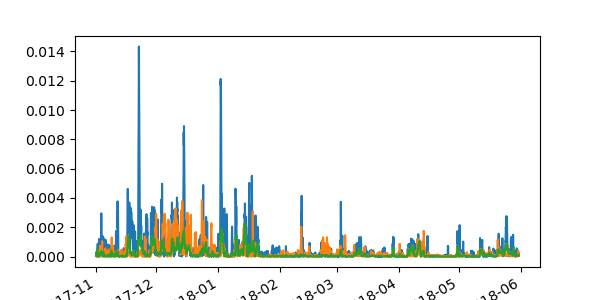

In [218]:
dsc_i['u_shr_ext'] = dsc_i['u'].copy(deep=True)
dsc_i['v_shr_ext'] = dsc_i['v'].copy(deep=True)

fig, axs = plt.subplots(figsize=(6,3))

# --------- surface shear ----------------
u_shear_sfc = dsc_i.u.sel(depth=slice(-15,-10)).diff('depth').mean('depth')
v_shear_sfc = dsc_i.v.sel(depth=slice(-15,-10)).diff('depth').mean('depth')

# --------- bottom shear ----------------
u_shear_bot = dsc_i.u.sel(depth=slice(-30,-25)).diff('depth').mean('depth')
v_shear_bot = dsc_i.v.sel(depth=slice(-30,-25)).diff('depth').mean('depth')

# --------- depth mean shear ----------------
u_shear_blk = dsc_i.u.diff('depth').mean('depth')
v_shear_blk = dsc_i.v.diff('depth').mean('depth')


# dpdz = -dso_i.sig0.diff('depth').mean('depth')
# N2 = (9.8/1025)*dpdz
(u_shear_sfc**2+v_shear_sfc**2).plot()
(u_shear_bot**2+v_shear_bot**2).plot()
(u_shear_blk**2+v_shear_blk**2).plot()
# ((9.8/1025)*dpdz).plot()





#### Find depths where data nearly always available

In [223]:
nan_fracs = (dsc.u.sel(time=time_range2).isnull().sum('time') / len(dsc.sel(time=time_range2).time))

deep = np.round(nan_fracs[(nan_fracs < 0.05)].depth.min().item())
srfc = np.floor(nan_fracs[(nan_fracs < 0.05)].depth.max().item())

print(deep, srfc)

-30.0 -8.0


In [224]:


for depth in np.arange(-40,deep):
    dy = depth - (deep)
    dsc_i['u_shr_ext'].loc[dict(depth=depth)] = dsc_i.u.sel(depth=deep) + dy * (u_shear_blk)
    dsc_i['v_shr_ext'].loc[dict(depth=depth)] = dsc_i.v.sel(depth=deep) + dy * (v_shear_blk)
    
for depth in np.arange(srfc,0+1):
    dy = depth - (srfc)
    dsc_i['u_shr_ext'].loc[dict(depth=depth)] = dsc_i.u.sel(depth=srfc) + dy * (u_shear_blk)
    dsc_i['v_shr_ext'].loc[dict(depth=depth)] = dsc_i.v.sel(depth=srfc) + dy * (v_shear_blk)
    
dsc_i['u_shr_ext'] = dsc_i['u_shr_ext'].interpolate_na(dim='time', method='linear')
dsc_i['v_shr_ext'] = dsc_i['v_shr_ext'].interpolate_na(dim='time', method='linear')
dsc_i['se_shr_ext'] = vectors.comp_along_theta(dsc_i['u_shr_ext'], dsc_i['v_shr_ext'], 145*units('deg'))


<IPython.core.display.Javascript object>


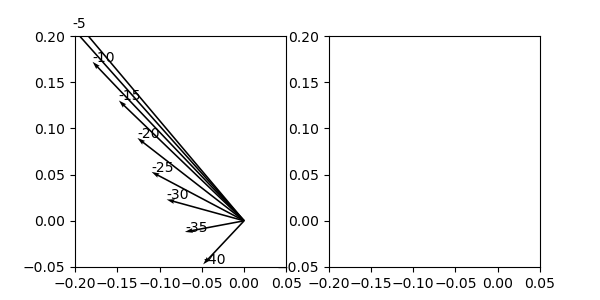

In [225]:
fig, axs = plt.subplots(1,2, figsize=(6,3))

for ax in axs:
    ax.set_xlim(-0.2,0.05)
    ax.set_ylim(-0.05,0.2)

for depth in dsc_i.depth.values[::5]:
    
    
    axs[0].quiver(np.array([0]), np.array([0]), 
               dsc_i.u_shr_ext.sel(depth=depth).mean('time'), 
               dsc_i.v_shr_ext.sel(depth=depth).mean('time'), scale=1, angles='xy', scale_units='xy')
    
    axs[0].text(dsc_i.u_shr_ext.sel(depth=depth).mean('time'), 
               dsc_i.v_shr_ext.sel(depth=depth).mean('time'), depth)

<IPython.core.display.Javascript object>


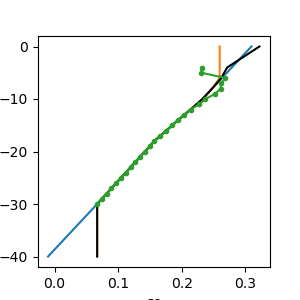

In [226]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(3,3))

dsc_i['se_shr_ext'].sel(time=time_range2).mean('time').plot(y='depth')
dsc_i['se_val_ext'].sel(time=time_range2).mean('time').plot(y='depth')
dsc_i['se_ice_ext'].sel(time=time_range2).mean('time').plot(y='depth', c='k')
dsc_i['se'].sel(time=time_range2).mean('time').plot(y='depth', marker='.')

<IPython.core.display.Javascript object>


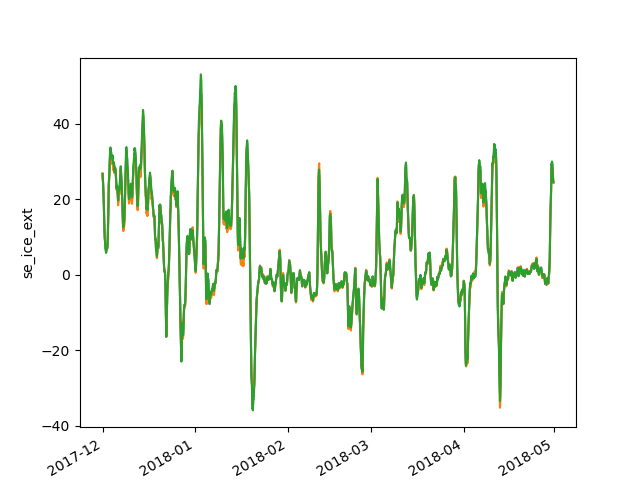

In [227]:
fig, ax = plt.subplots()
dsc_i['se_val_ext'].sel(time=time_range2).integrate('depth').plot()
dsc_i['se_shr_ext'].sel(time=time_range2).integrate('depth').plot()
dsc_i['se_ice_ext'].sel(time=time_range2).integrate('depth').plot()

<IPython.core.display.Javascript object>


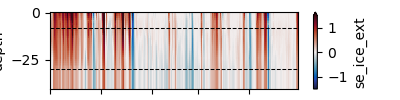

In [228]:
fig, ax = plt.subplots(figsize=(4,1))
dsc_i.se_ice_ext.sel(time=time_range2).plot(vmin=-1.5, vmax=1.5, cmap=cmocean.cm.balance)
ax.axhline(deep, c='k', ls='dashed', lw=0.75)
ax.axhline(srfc, c='k', ls='dashed', lw=0.75)

In [229]:
vol_val_ext = dsc_i.se_val_ext.sel(time=time_range2).integrate('depth')
vol_ice_ext = dsc_i.se_ice_ext.sel(time=time_range2).integrate('depth')
vol_shr_ext = dsc_i.se_shr_ext.sel(time=time_range2).integrate('depth')


print(1 - vol_val_ext.integrate('time') / vol_shr_ext.integrate('time'))
print(1 - vol_ice_ext.integrate('time') / vol_shr_ext.integrate('time'))
print(1 - vol_ice_ext.integrate('time') / vol_val_ext.integrate('time'))

<xarray.DataArray ()>
array(-0.03770401)
<xarray.DataArray ()>
array(-0.0657422)
<xarray.DataArray ()>
array(-0.02701944)


In [230]:
# less than 2.7 percent relative differences in volume flux

## Approaches for extrapolating hydrographic data

#### (1) val_ext: extrapolate nearest surface/bottom values to bounds
#### (2) lin_ext: interpolate between nearest surface value and ice velocity, interpolate nearest-to-bottom value to zero at bottom
#### (3) shr_ext: extrapolate bulk mean velocity shear between 15-10 m between 10 m and the surface, extrapolate bulk mean velocity shear between 25-30 m between 30 m and the bottom. 

In [231]:
# ---------- interpolate to standard depth intervals ----------
d_depth = np.arange(-40,0+1, 1)

dso_i = dso.copy(deep=True).interp(depth = d_depth)

dso_i['Ct_val_ext'] = dso_i['Ct'].copy(deep=True)
dso_i['Tf_val_ext'] = dso_i['Tf'].copy(deep=True)

# extrapolate values to the surface
dso_i['Ct_val_ext'] = dso_i['Ct_val_ext'].interpolate_na(dim='depth', method='nearest',  fill_value = "extrapolate")
dso_i['Tf_val_ext'] = dso_i['Tf_val_ext'].interpolate_na(dim='depth', method='nearest',  fill_value = "extrapolate")
dso_i['dT_val_ext'] = dso_i['Ct_val_ext'] - dso_i['Tf_val_ext']

In [232]:


dso_i['Ct_sfc_ext'] = dso_i['Ct'].copy(deep=True)
dso_i['Tf_sfc_ext'] = dso_i['Tf'].copy(deep=True)

sfc_freeze = dso_i['Tf'].sel(depth=-16)

dso_i['Ct_sfc_ext'].loc[dict(depth=0)] = dso_i['Ct_sfc_ext'].sel(depth=0).fillna(sfc_freeze)
dso_i['Tf_sfc_ext'].loc[dict(depth=0)] = dso_i['Tf_sfc_ext'].sel(depth=0).fillna(sfc_freeze)

dso_i['Ct_sfc_ext'].loc[dict(depth=-40)] = dso_i['Ct_sfc_ext'].sel(depth=-40).fillna(dso_i['Ct'].sel(depth=dso.depth.min()))
dso_i['Tf_sfc_ext'].loc[dict(depth=-40)] = dso_i['Tf_sfc_ext'].sel(depth=-40).fillna(dso_i['Tf'].sel(depth=dso.depth.min()))

dso_i['Ct_sfc_ext'] = dso_i['Ct_sfc_ext'].interpolate_na(dim='depth', method='linear',  fill_value = "extrapolate")
dso_i['Tf_sfc_ext'] = dso_i['Tf_sfc_ext'].interpolate_na(dim='depth', method='linear',  fill_value = "extrapolate")

dso_i['dT_sfc_ext'] = dso_i['Ct_sfc_ext'] - dso_i['Tf_sfc_ext']



for var in ['Ct', 'Tf', 'dT', 'Sa']:
    
    dso_i[f'{var}_lin_ext'] = dso_i[var].copy(deep=True)
    
    dso_i[f'{var}_lin_ext'] = dso_i[f'{var}_lin_ext'].interpolate_na(dim='depth', method='linear',  fill_value = "extrapolate")
    
dso_i['dT_lin_ext'] = dso_i['dT_lin_ext'].clip(min=0)

dso_i['Ct_lin_ext'] = dso_i['Ct_lin_ext'].clip(min=dso_i['Tf_lin_ext'])

dso_i['dT_lin_ext2'] = dso_i['Ct_lin_ext'] - dso_i['Tf_lin_ext']


<IPython.core.display.Javascript object>


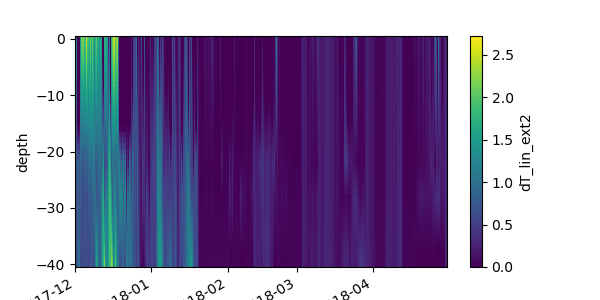

In [233]:
fig, axs = plt.subplots(figsize=(6,3))

(dso_i[f'dT_lin_ext2']).sel(time=time_range2).plot()


<IPython.core.display.Javascript object>


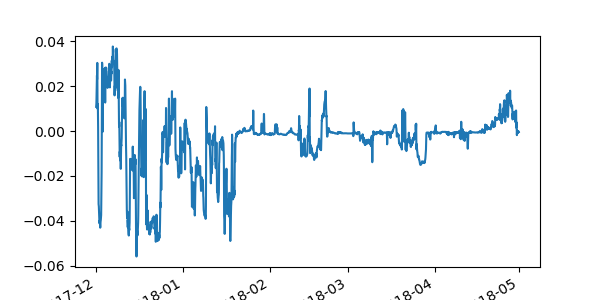

In [234]:

for var in ['dT', 'Ct', 'Tf', 'Sa', 'sig0']:
    dso_i[f'{var}_shr_ext'] = dso_i[var].copy(deep=True)


fig, axs = plt.subplots(figsize=(6,3))

# --------- depth mean temp gradient ----------------
grad_blk = {}
    
for var in ['dT', 'Ct', 'Tf', 'Sa', 'sig0']:
    grad_blk[var] = (dso_i[var].diff('depth')/dso_i.depth.diff('depth')).mean('depth')

# Ct_grad_blk.sel(time=time_range2).plot()
# Tf_grad_blk.sel(time=time_range2).plot()
# dT_grad_blk.sel(time=time_range2).plot()

grad_blk['dT'].sel(time=time_range2).plot()


In [235]:
nan_fracs = (dso.Ct.sel(time=time_range2).isnull().sum('time') / len(dso.sel(time=time_range2).time))

deepT = nan_fracs[(nan_fracs == 0)].depth.min().item()
srfcT = nan_fracs[(nan_fracs == 0)].depth.max().item()

print(deepT, srfcT)

-36.0 -16.0


In [191]:
dy * grad_blk['dT'].values

array([-0.00134836, -0.00220412, -0.00232233, ..., -0.00950668,
       -0.00847164, -0.00570326])

In [236]:

for var in ['dT', 'Ct', 'Tf', 'Sa', 'sig0']:
    
    for depth in np.arange(-40,deepT):
        dy = depth - (deepT)

        dso_i[f'{var}_shr_ext'].loc[dict(depth=depth)] = dso_i[var].sel(depth=deepT) + dy * (grad_blk[var].values)

    for depth in np.arange(srfcT+1,0+1):
        dy = depth - (srfcT)
        dso_i[f'{var}_shr_ext'].loc[dict(depth=depth)] = dso_i[var].sel(depth=srfcT) + dy * (grad_blk[var].values)
    
    dso_i[f'{var}_shr_ext'] = dso_i[f'{var}_shr_ext'].interpolate_na(dim='time', method='linear')

import gsw
import gsw.freezing
# sea pressure ( i.e. absolute pressure - 10.1325 dbar )
p = gsw.conversions.p_from_z(dso_i['depth'], dso.attrs['lat'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
# freezing point of water
dso_i['Tf_shr_ext'] = gsw.freezing.CT_freezing(dso_i['Sa_shr_ext'], p, 1)
    
dso_i['dT_shr_ext'] = dso_i['dT_shr_ext'].clip(min=0)

dso_i['Ct_shr_ext'] = dso_i['Ct_shr_ext'].clip(min=dso_i['Tf_shr_ext'])
dso_i['dT2_shr_ext'] = dso_i['Ct_shr_ext'] - dso_i['Tf_shr_ext'] 


<IPython.core.display.Javascript object>


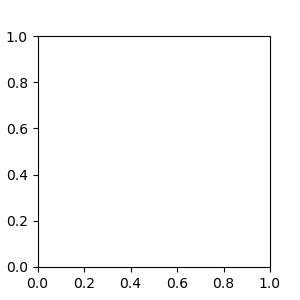

KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

In [237]:
fig, ax = plt.subplots(figsize=(3,3))

ds_time = dso_i.sel(time=time_range2)
# .sel(time=event_times)

ds_time['dT_shr_ext'].sel(time=datetime(2017,1,8)).plot(y='depth')
ds_time['dT_val_ext'].sel(time=datetime(2017,1,8)).plot(y='depth')
# ds_time['dT_lin_ext'].mean('time').plot(y='depth')
# ds_time['dT_sfc_ext'].sel(time=event_times).sel(time=time_range2).mean('time').plot(y='depth', marker='.')
# ds_time['dT'].mean('time').plot(y='depth', marker='.')

# dso_i['dT_shr_ext'].sel(time=event_times==False).sel(time=time_range2).mean('time').plot(y='depth')
# dso_i['dT'].sel(time=event_times==False).sel(time=time_range2).mean('time').plot(y='depth', marker='.')

<IPython.core.display.Javascript object>


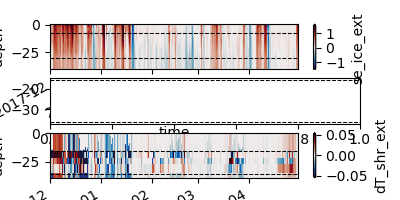

In [273]:
fig, axs = plt.subplots(3,1,figsize=(4,2))


(dsc_i['se_ice_ext']).sel(time=time_range2).plot(ax = axs[0], vmin=-1.5, vmax=1.5, cmap=cmocean.cm.balance)

for ax in axs[:1]:
    ax.axhline(deep, c='k', ls='dashed', lw=0.75)
    ax.axhline(srfc, c='k', ls='dashed', lw=0.75)
    
    
# dso_i['sig0_val_ext'].sel(time=time_range2).plot(ax = axs[1], vmin=24, vmax=27, cmap=cmocean.cm.haline)

# (dso_i['dT_val_ext']).sel(time=time_range2).plot(ax = axs[2], vmin=0, vmax=1.5, cmap=cmocean.cm.amp)

# dso_i['dT_mean'] = xr.concat([dso_i['dT_sfc_ext'], dso_i['dT_lin_ext']], dim="method").mean(dim="method")

# dso_i['dT_lin_ext'].sel(time=time_range2).plot(ax = axs[2], vmin=0, vmax=1.5, cmap=cmocean.cm.amp)

# (dso_i['dT_mean']).sel(time=time_range2).plot(ax = axs[2], vmin=-1.5, vmax=1.5, cmap=cmocean.cm.balance)

# (dso_i['dT_val_ext']).sel(time=time_range2).plot(ax = axs[2], vmin=-1.5, vmax=1.5, cmap=cmocean.cm.balance)


# (dso_i['dT_shr_ext']).sel(time=time_range2).plot(ax = axs[2], vmin=-1.5, vmax=1.5, cmap=cmocean.cm.balance)


(dso_i['dT_shr_ext'].diff('depth')).sel(time=time_range2).plot(ax = axs[2], vmin=-0.05, vmax=0.05, cmap=cmocean.cm.balance)


for ax in axs[1:]:
    ax.axhline(deepT, c='k', ls='dashed', lw=0.75)
    ax.axhline(srfcT, c='k', ls='dashed', lw=0.75)

# for ax in axs:    
#     ax.set_xlim(datetime(2016,12,1), datetime(2017,1,1))


<IPython.core.display.Javascript object>


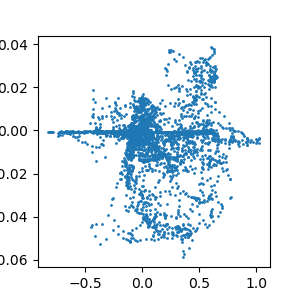

In [298]:
fig, ax = plt.subplots(figsize=(3,3))



x = (dsc_i['se_shr_ext'].sel(depth=slice(-35,-16)).mean('depth')).sel(time=time_range2)
y = (dso_i['dT_shr_ext'].sel(depth=slice(-35,-16)).diff('depth').mean('depth')).sel(time=time_range2)

# plt.plot(x/15)
# plt.plot(y)

ax.scatter(x,y, s=1)


<IPython.core.display.Javascript object>


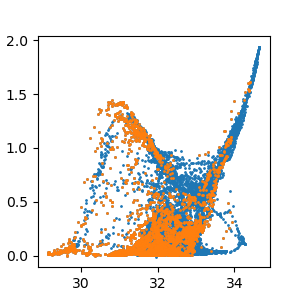

KeyError: "not all values found in index 'depth'. Try setting the `method` keyword argument (example: method='nearest')."

In [239]:
fig, ax = plt.subplots(figsize=(3,3))
# ds_time = dso.sel(time=event_times).sel(time=time_range2)

ds_time = dso.sel(time=time_range2)

ax.scatter(ds_time.Sa, ds_time.dT, s=1)
ax.scatter(ds_time.Sa.sel(depth=-16), ds_time.dT.sel(depth=-16), s=1)
ax.scatter(ds_time.Sa.sel(depth=-39), ds_time.dT.sel(depth=-39), s=1)

In [257]:
event_times

<xarray.DataArray 'se' (time: 5064)>
array([False, False, False, ...,  True,  True,  True])
Coordinates:
  * time     (time) datetime64[ns] 2017-11-01 ... 2018-05-30T23:00:00

<IPython.core.display.Javascript object>


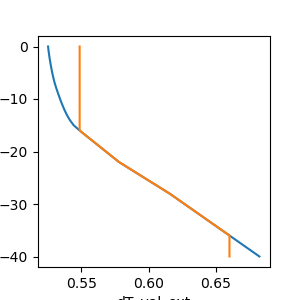

In [260]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(3,3))

ds_time = dso_i.sel(time=event_times).sel(time=time_range2)
# ds_time = dso_i.sel(time=time_range2)

var = 'dT'

ds_time[f'{var}_shr_ext'].mean('time').plot(y='depth')
# ds_time[f'{var}2_shr_ext'].mean('time').plot(y='depth')

ds_time[f'{var}_val_ext'].mean('time').plot(y='depth')
# ds_time[f'{var}_sfc_ext'].mean('time').plot(y='depth', c='gray')
# ds_time['dT_lin_ext'].mean('time').plot(y='depth')
# ds_time[f'{var}_mean'].mean('time').plot(y='depth', c='k')
# ds_time[f'{var}'].mean('time').plot(y='depth', marker='.', c='b')

# (ds_time[f'{var}'].mean('time')+0.5*ds_time['dT'].std('time')).plot(y='depth', marker='.', c='b')
# (ds_time[f'{var}'].mean('time')-0.5*ds_time['dT'].std('time')).plot(y='depth', marker='.', c='b')


In [267]:
dso_i['dT_cold'] = dso_i['dT_val_ext'].copy(deep=True)
dso_i['dT_cold'][dso_i['dT_cold'].depth>-16] = 0

<IPython.core.display.Javascript object>


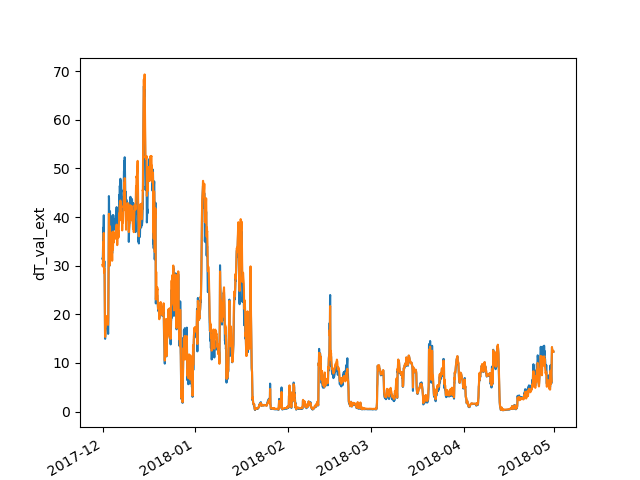

In [268]:
fig, ax = plt.subplots()
# dso_i['dT_shr_ext'].sel(time=time_range2).integrate('depth').plot()
# dso_i['dT_cold'].sel(time=time_range2).integrate('depth').plot()
# dso_i['dT_sfc_ext'].sel(time=time_range2).integrate('depth').plot()
dso_i['dT_shr_ext'].sel(time=time_range2).integrate('depth').plot()
dso_i['dT_val_ext'].sel(time=time_range2).integrate('depth').plot()
# dso_i['dT_mean'].sel(time=time_range2).integrate('depth').plot()

<IPython.core.display.Javascript object>


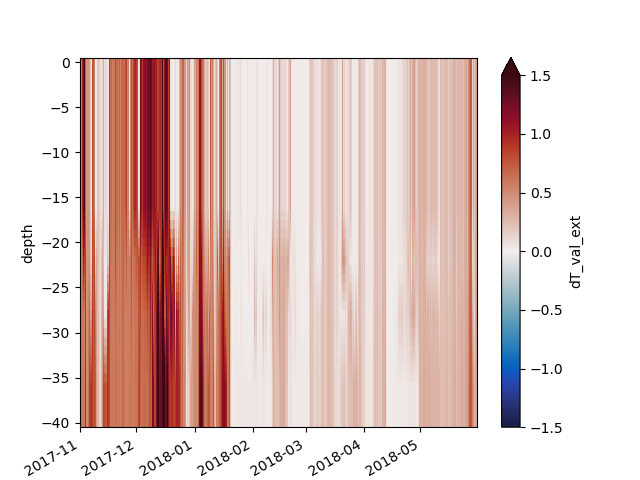

In [244]:
fig, ax= plt.subplots()
dso_i['dT_val_ext'].plot(vmin=-1.5, vmax=1.5, cmap=cmocean.cm.balance)

In [299]:
# dT_mean = dso_i.dT_mean.sel(time=time_range2).integrate('depth')
# dT_cold = dso_i.dT_cold.sel(time=time_range2).integrate('depth')
dT_val_ext = dso_i.dT_val_ext.sel(time=time_range2).integrate('depth')
dT_shr_ext = dso_i.dT_shr_ext.sel(time=time_range2).integrate('depth')
dT_sfc_ext = dso_i.dT_sfc_ext.sel(time=time_range2).integrate('depth')
dT_lin_ext = dso_i.dT_lin_ext.sel(time=time_range2).integrate('depth')

# print(1 - dT_cold.integrate('time') / dT_sfc_ext.integrate('time'))
# print(1 - dT_mean.integrate('time') / dT_lin_ext.integrate('time'))
print(1 - dT_lin_ext.integrate('time') / dT_val_ext.integrate('time'))
print(1 - dT_shr_ext.integrate('time') / dT_val_ext.integrate('time'))
print(1 - dT_lin_ext.integrate('time') / dT_val_ext.integrate('time'))
# print(1 - dT_shr_ext.integrate('time') / dT_sfc_ext.integrate('time'))

<xarray.DataArray ()>
array(-0.00773057)
<xarray.DataArray ()>
array(0.01729707)
<xarray.DataArray ()>
array(-0.00773057)


<IPython.core.display.Javascript object>


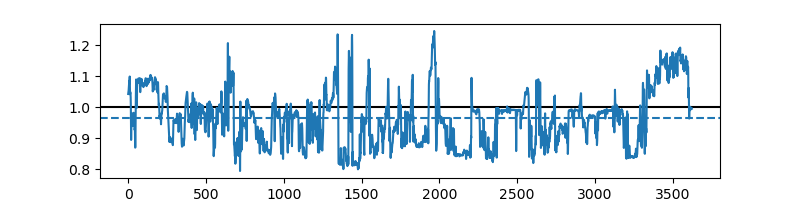

0.9651641791561327


In [300]:
# np.nanstd(dT_shr_ext / dT_val_ext)
fig, ax= plt.subplots(figsize=(8,2))
plt.plot(dT_shr_ext / dT_val_ext)

mean_ratio = np.nanmean(dT_shr_ext / dT_val_ext)
print(mean_ratio)
plt.axhline(mean_ratio, ls='dashed')
plt.axhline(1, c='k', zorder=-1)

<xarray.DataArray ()>
array(-0.03770401)


<IPython.core.display.Javascript object>


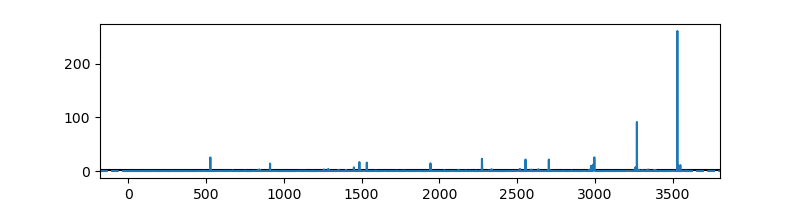

0.2966817383277538


In [301]:

se_val_ext = dsc_i.se_val_ext.sel(time=time_range2).integrate('depth')
se_shr_ext = dsc_i.se_shr_ext.sel(time=time_range2).integrate('depth')

print(1 - se_val_ext.integrate('time') / se_shr_ext.integrate('time'))

# np.nanstd(dT_shr_ext / dT_val_ext)
fig, ax= plt.subplots(figsize=(8,2))
# plt.plot(se_shr_ext / se_val_ext)

plt.plot(abs(se_shr_ext - se_val_ext)/abs(se_val_ext))
# plt.plot(se_shr_ext)

# median_ratio = np.nanpercentile(abs(se_shr_ext / se_val_ext), 90)

mean_ratio = np.nanmean(abs(se_shr_ext - se_val_ext)/abs(se_val_ext))
print(mean_ratio)
plt.axhline(mean_ratio, ls='dashed')
plt.axhline(1, c='k', zorder=-1)



In [203]:
# temp diff b/w constant extrapolation and extrapolation of bulk mean temp gradient

# -0.6% difference in 2016/17
# 1.7% difference in 2017/18

# velocity diff b/w constant extrapolation and extrapolation of bulk mean temp gradient

# -1.3% difference in 2016/17
# -4.4% difference in 2017/18

In [206]:
-1.3+-4.4

-5.7

In [39]:
0.75*12

9.0

In [111]:
ht_val_ext = (dsc_i.se_ice_ext * dso_i.dT_val_ext).sel(time=time_range2).integrate('depth')
ht_cold = (dsc_i.se_ice_ext * dso_i.dT_cold).sel(time=time_range2).integrate('depth')
ht_shr_ext = (dsc_i.se_ice_ext * dso_i.dT_shr_ext).sel(time=time_range2).integrate('depth')
ht_sfc_ext = (dsc_i.se_ice_ext * dso_i.dT_sfc_ext).sel(time=time_range2).integrate('depth')
ht_lin_ext = (dsc_i.se_ice_ext * dso_i.dT_lin_ext).sel(time=time_range2).integrate('depth')

print(1 - ht_cold.integrate('time') / ht_val_ext.integrate('time'))
print(1 - ht_sfc_ext.integrate('time') / ht_lin_ext.integrate('time'))
print(1 - ht_shr_ext.integrate('time') / ht_lin_ext.integrate('time'))
print(1 - ht_shr_ext.integrate('time') / ht_sfc_ext.integrate('time'))

AttributeError: 'Dataset' object has no attribute 'dT_cold'

### Save to netcdf

In [1672]:
12*0.55

6.6000000000000005

In [1673]:
ds = xr.merge([dso_i, dsc_i])

ds.to_netcdf(f'../data/oht_M1_{open_years}.nc')

In [1674]:
ds

<xarray.Dataset>
Dimensions:       (time: 5064, depth: 41)
Coordinates:
  * time          (time) datetime64[ns] 2016-11-01 ... 2017-05-30T23:00:00
  * depth         (depth) int64 -40 -39 -38 -37 -36 -35 -34 ... -5 -4 -3 -2 -1 0
Data variables: (12/37)
    T             (depth, time) float64 nan nan nan nan nan ... nan nan nan nan
    Sp            (depth, time) float64 nan nan nan nan nan ... nan nan nan nan
    Sa            (depth, time) float64 nan nan nan nan nan ... nan nan nan nan
    Ct            (depth, time) float64 nan nan nan nan nan ... nan nan nan nan
    Tf            (depth, time) float64 nan nan nan nan nan ... nan nan nan nan
    sig0          (depth, time) float64 nan nan nan nan nan ... nan nan nan nan
    ...            ...
    u_ice_ext     (depth, time) float64 -0.6927 -0.4952 ... -0.3033 -0.06465
    v_ice_ext     (depth, time) float64 0.2298 0.1331 0.1244 ... 0.1568 0.1173
    se_ice_ext    (depth, time) float64 0.6992 0.482 0.4571 ... 0.3384 0.1203
    u_shr_ext     (depth, time) float64 nan -0.4065 -0.4361 ... -0.2894 -0.3044
    v_shr_ext     (depth, time) float64 nan -0.06906 -0.07741 ... 0.3602 0.4553
    se_shr_ext    (depth, time) float64 nan 0.2934 0.3129 ... 0.4437 0.5105
Attributes:
    lat:      69.7706
    lon:      -139.2548

In [1230]:
# ht_shr_ext = (dsc_i.se_shr_ext * dso_i.dT_shr_ext).sel(time=event_times).sel(time=time_range2).integrate('depth')
# ht_val_ext = (dsc_i.se_val_ext * dso_i.dT_val_ext).sel(time=event_times).sel(time=time_range2).integrate('depth')
# ht_lin_ext = (dsc_i.se_lin_ext * dso_i.dT_lin_ext).sel(time=event_times).sel(time=time_range2).integrate('depth')

# print(1 - ht_val_ext.integrate('time') / ht_lin_ext.integrate('time'))
# print(1 - ht_shr_ext.integrate('time') / ht_lin_ext.integrate('time'))
# print(1 - ht_shr_ext.integrate('time') / ht_val_ext.integrate('time'))

<IPython.core.display.Javascript object>


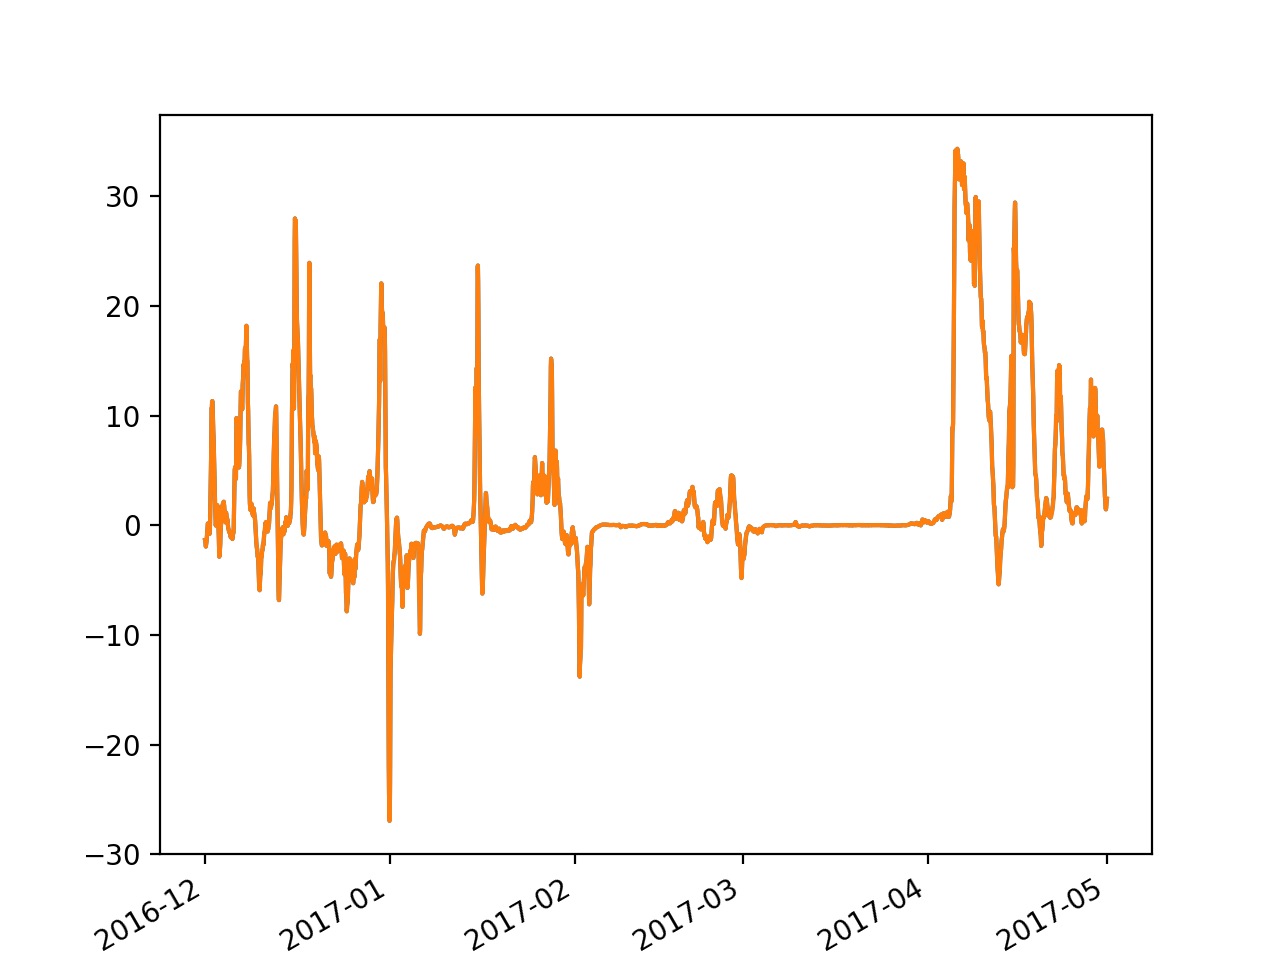

In [1231]:
fig, ax = plt.subplots()
# (dso_i.Ct.max('depth') - dso_i.Ct.min('depth').sel(time=time_range2)).plot()
# (dso_i.dT.sel(depth=-16, time=time_range2)).plot()
ht_shr_ext.plot()
ht_shr_ext.plot()

<IPython.core.display.Javascript object>


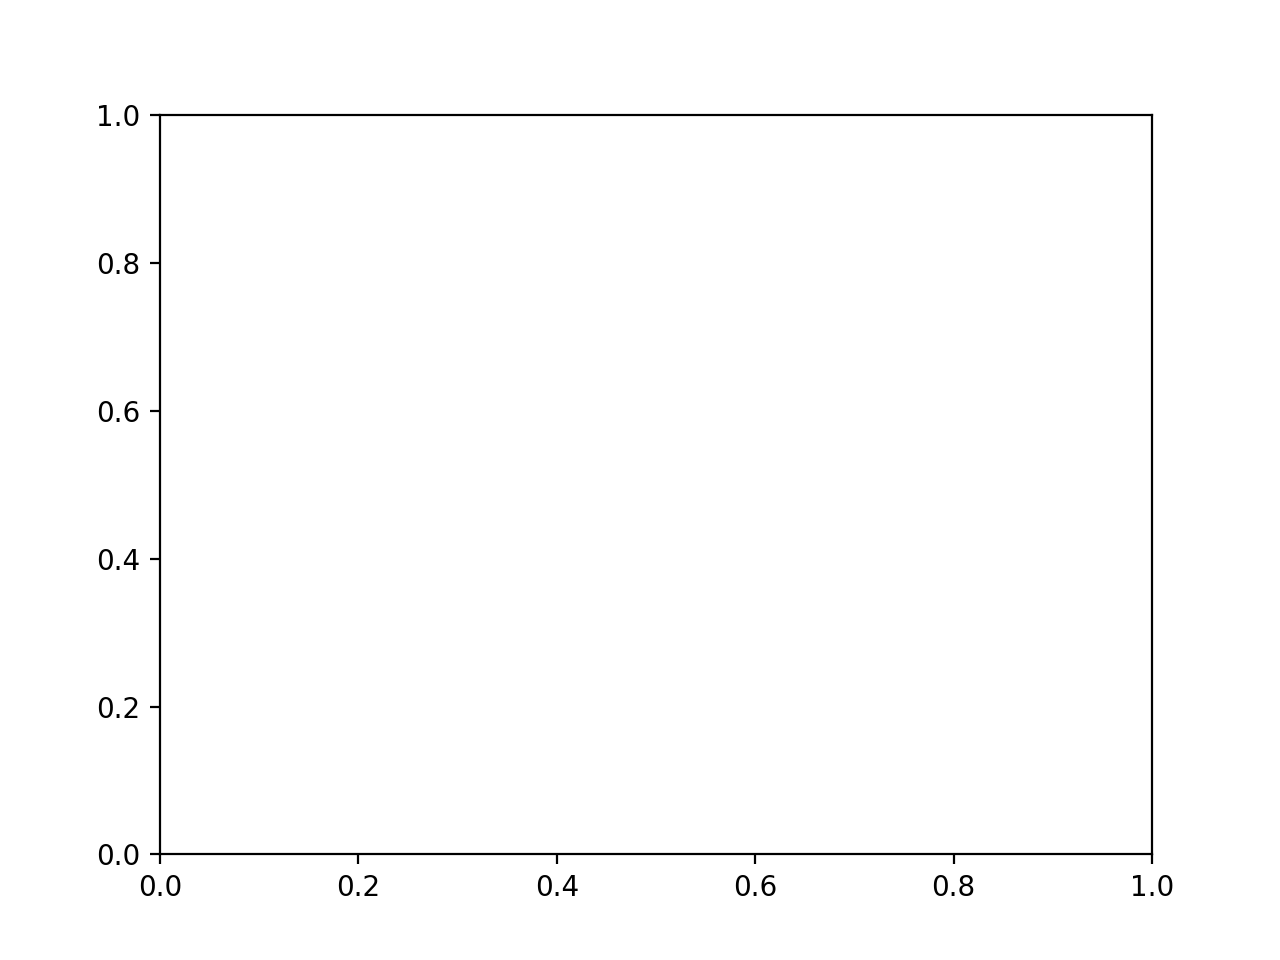

AttributeError: 'Dataset' object has no attribute 'dT_loc_ext'

In [1233]:
fig, ax = plt.subplots()

t_11 = (dso_i.dT_loc_ext * dsc_i.se_shr_ext).sel(time=time_range2).integrate('depth')
t_21 = (dso_i.dT_lin_ext * dsc_i.se_shr_ext).sel(time=time_range2).integrate('depth')
t_31 = (dso_i.dT_val_ext * dsc_i.se_shr_ext).sel(time=time_range2).integrate('depth')

t_12 = (dso_i.dT_loc_ext * dsc_i.se_val_ext).sel(time=time_range2).integrate('depth')
t_22 = (dso_i.dT_lin_ext * dsc_i.se_val_ext).sel(time=time_range2).integrate('depth')
t_32 = (dso_i.dT_val_ext * dsc_i.se_val_ext).sel(time=time_range2).integrate('depth')

t_13 = (dso_i.dT_loc_ext * dsc_i.se_lin_ext).sel(time=time_range2).integrate('depth')
t_23 = (dso_i.dT_lin_ext * dsc_i.se_lin_ext).sel(time=time_range2).integrate('depth')
t_33 = (dso_i.dT_val_ext * dsc_i.se_lin_ext).sel(time=time_range2).integrate('depth')

t_11.plot()
t_21.plot()
t_31.plot()

t_12.plot()
t_22.plot()
t_32.plot()

t_13.plot()
t_23.plot()
t_33.plot()

In [566]:
t_11.integrate('time')

<xarray.DataArray ()>
array(3.30015696e+16)

In [567]:
t_11_mean = t_11.integrate('time')
t_21_mean = t_21.integrate('time')
t_31_mean = t_31.integrate('time')

t_12_mean = t_12.integrate('time')
t_22_mean = t_22.integrate('time')
t_32_mean = t_32.integrate('time')

t_13_mean = t_13.integrate('time')
t_23_mean = t_23.integrate('time')
t_33_mean = t_33.integrate('time')

In [580]:
# print((t_11_mean/t_21_mean) - 1)

print((t_11_mean/t_31_mean) - 1)
print((t_11_mean/t_13_mean) - 1)
print((t_11_mean/t_33_mean) - 1)



<xarray.DataArray ()>
array(-0.006337)
<xarray.DataArray ()>
array(0.05876995)
<xarray.DataArray ()>
array(0.04385276)


In [544]:
np.sqrt(0.031**2 + 0.027**2)

0.04110960958218893

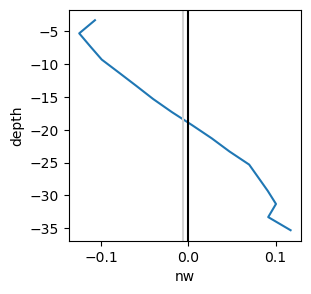

In [982]:
fig, ax = plt.subplots(figsize=(3,3))
dsc.nw.sel(time = dsc.se.mean('depth')>0.25).mean('time').plot(y='depth')
plt.axvline(0, c='k')

plt.axvline(dsc.nw.sel(time = dsc.se.mean('depth')>0.25).mean('time').mean('depth'), c='lightgray')

In [983]:
# ---------- interpolate to standard depth intervals ----------
d_depth = np.arange(-40,0+1, 1)
di = xr.merge([dso.interp(depth = d_depth), dsc.interp(depth = d_depth)])


In [984]:

# # ---------- interpolate to standard depth intervals ----------
# di = xr.merge([dso.interp(depth = d_depth), dsc.interp(depth = d_depth)])

# # ---------- first pass to interpolate linearly across nans ----------
# di_base = di.interpolate_na(dim = 'depth', method='linear')
# di_base = di_base.interpolate_na(dim='time', method='linear', max_gap='24H', use_coordinate=True)


# surface conditions
# ---------- interpolate to sea ice velocity ----------------
# ds3 = ds3.interpolate_na(dim='time', method='linear', max_gap='24H', use_coordinate=True)
# sfc_u = ds3.u.values
# sfc_v = ds3.v.values
# di_base['u'].loc[dict(depth=0)] = di_base['u'].sel(depth=0).fillna(sfc_u)
# di_base['v'].loc[dict(depth=0)] = di_base['v'].sel(depth=0).fillna(sfc_v)

# ---------- fill surface temp with nearest-to-surface freezing temp ----------------
di_base_ice = di.copy(deep=True)

sfc_freeze = dso.Tf.sel(depth=-16).values
sfc_temp = dso.Ct.sel(depth=-16).values
di_base_ice['Ct'].loc[dict(depth=0)] = di_base_ice['Ct'].sel(depth=0).fillna(sfc_freeze)
di_base_ice['Tf'].loc[dict(depth=0)] = di_base_ice['Tf'].sel(depth=0).fillna(sfc_freeze)

# ---------- fill surface velocity with ice velocity ----------------
di_base_ice['se'].loc[dict(depth=0)] = di_base_ice['se'].sel(depth=0).fillna(dsi.se.sel(depth=0))
di_base_ice['u'].loc[dict(depth=0)] = di_base_ice['u'].sel(depth=0).fillna(dsi.se.sel(depth=0))
di_base_ice['v'].loc[dict(depth=0)] = di_base_ice['v'].sel(depth=0).fillna(dsi.se.sel(depth=0))


# di_val_ext = di.interpolate_na(dim='depth', method='nearest', fill_value = "extrapolate")
di_lin_ext_sfcT_sfcice = di_base_ice.interpolate_na(dim='depth', method='linear', fill_value = "extrapolate")




# ---------- fill surface temp with nearest-to-surface freezing temp ----------------
di_base = di.copy(deep=True)

sfc_freeze = dso.Tf.sel(depth=-16).values
sfc_temp = dso.Ct.sel(depth=-16).values
di_base['Ct'].loc[dict(depth=0)] = di_base['Ct'].sel(depth=0).fillna(sfc_freeze)
di_base['Tf'].loc[dict(depth=0)] = di_base['Tf'].sel(depth=0).fillna(sfc_freeze)

# di_val_ext = di.interpolate_na(dim='depth', method='nearest', fill_value = "extrapolate")
di_lin_ext_sfcT = di_base.interpolate_na(dim='depth', method='linear', fill_value = "extrapolate")


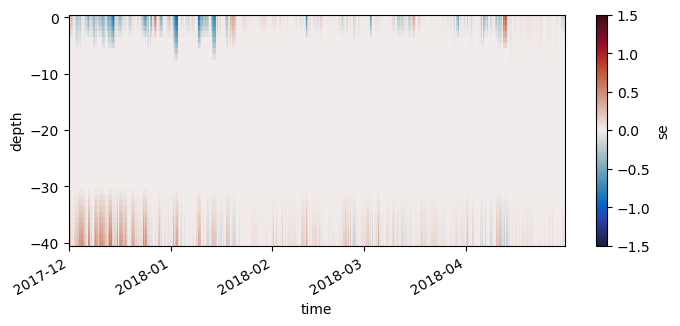

In [975]:
fig, ax = plt.subplots(figsize=(8,3))
(di_val_ext-di_lin_ext_sfcT_sfcice).se.sel(time=time_range2).plot(vmin=-1.5, vmax=1.5, cmap=cmocean.cm.balance)

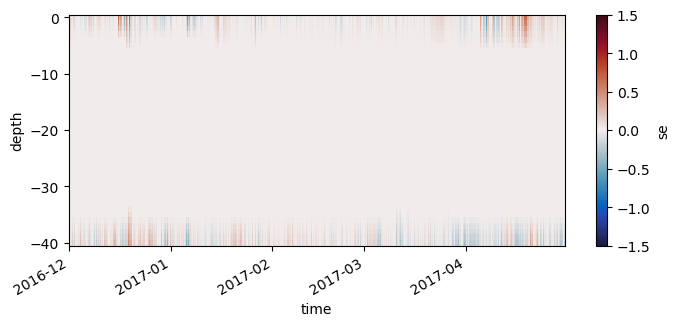

In [988]:
fig, ax = plt.subplots(figsize=(8,3))
(di_val_ext.se-di_lin_ext_sfcT_sfcice.se).sel(time=time_range2).plot(vmin=-1.5, vmax=1.5, cmap=cmocean.cm.balance)

In [985]:
#==================================
# temperature boundary conditions
#==================================

# bottom boundary: only make sense to extrapolate nearest values, or extrapolate 

# top boundary: note that dT (Ct-Tf) across upper two vertical intervals is ~ -0.1 deg / (16 meter)
# during strong along-polynya current (>0.25 m/s) events
# this is true of both years (-0.14260785, -0.10563035 in one year, -0.1025534 , -0.09093795 in the other)

# assume temp above freezing falls by 0.1 deg/meter from 16 m to surface
# estimated_surface = di['dT'].loc[dict(depth=-16)].values + (-0.1)
# estimated_surface[estimated_surface<0] = 0 # don't let fall below freezing

# di_ext = di.copy()
# di_ext['dT'].loc[dict(depth=0)] = di_ext['dT'].sel(depth=0).fillna(estimated_surface)


di_val_ext = di.interpolate_na(dim='depth', method='nearest', fill_value = "extrapolate")
di_lin_ext = di.interpolate_na(dim='depth', method='linear', fill_value = "extrapolate")

di_val_ext['dT'] = di_val_ext['dT'].clip(min=0)
di_lin_ext['dT'] = di_lin_ext['dT'].clip(min=0)


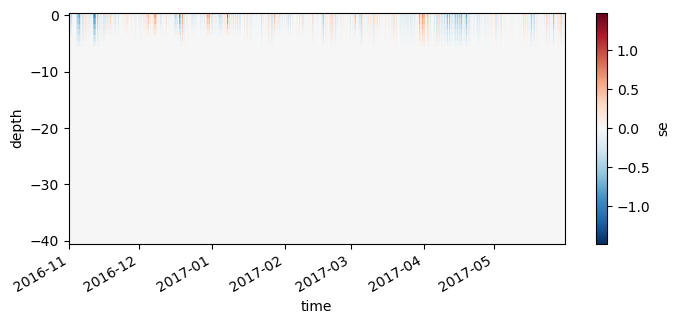

In [899]:
fig, ax = plt.subplots(figsize=(8,3))
(di_lin_ext_sfcT_sfcice.se-di_lin_ext.se).plot()

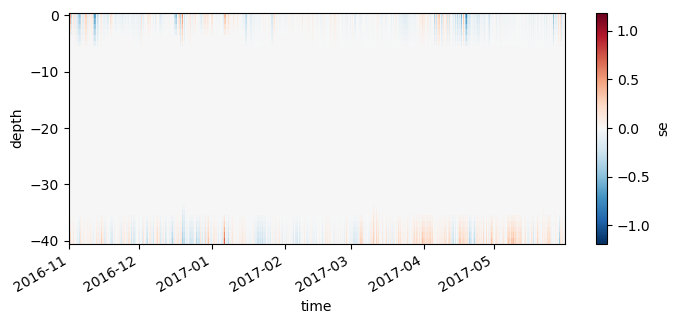

In [901]:
fig, ax = plt.subplots(figsize=(8,3))
(di_lin_ext_sfcT_sfcice.se-di_val_ext.se).plot()

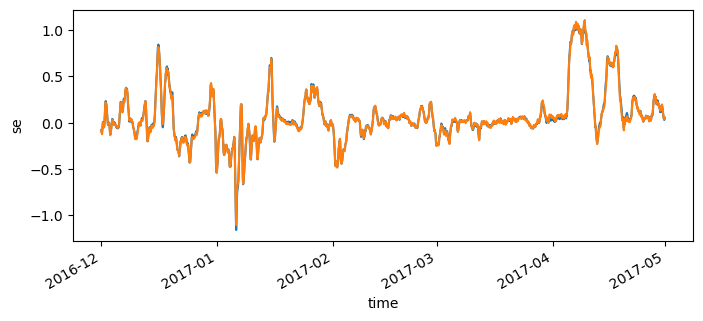

In [874]:
fig, ax = plt.subplots(figsize=(8,3))

(di_val_ext.se).sel(time=time_range2).mean('depth').plot()
(di_lin_ext_sfcT.se).sel(time=time_range2).mean('depth').plot()

In [875]:
(di_lin_ext_sfcT.se.integrate('depth') / di_val_ext.se.integrate('depth')).sel(time=time_range2).mean()

<xarray.DataArray 'se' ()>
array(1.04847569)

In [941]:
ohc_val_ext = cst['Cp_o'] * cst['rho_o'] * di_val_ext.sig0 * (di_val_ext.Ct - di_val_ext.Tf) 
oht_val_ext = (ohc_val_ext * di_val_ext.se).integrate('depth')


ohc_lin_ext = cst['Cp_o'] * cst['rho_o'] * di_lin_ext.sig0 * (di_lin_ext.Ct  - di_val_ext.Tf)
oht_lin_ext = (ohc_lin_ext * di_lin_ext.se).integrate('depth')


ohc_lin_ext_sfcT = cst['Cp_o'] * cst['rho_o'] * di_lin_ext_sfcT.sig0 * (di_lin_ext_sfcT.Ct  - di_lin_ext_sfcT.Tf)
oht_lin_ext_sfcT = (ohc_lin_ext_sfcT * di_lin_ext_sfcT.se).integrate('depth')


ohc_lin_ext_sfcT_sfcice = cst['Cp_o'] * cst['rho_o'] * di_lin_ext_sfcT_sfcice.sig0 * (di_lin_ext_sfcT_sfcice.Ct  - di_lin_ext_sfcT_sfcice.Tf)
oht_lin_ext_sfcT_sfcice = (ohc_lin_ext_sfcT_sfcice * di_lin_ext_sfcT_sfcice.se).integrate('depth')



In [942]:
(ohc_val_ext.integrate('depth')/ohc_lin_ext.integrate('depth')).sel(time=time_range2).mean()

<xarray.DataArray ()>
<Quantity(0.933496999, 'dimensionless')>

In [944]:
(ohc_lin_ext_sfcT.integrate('depth')/ohc_val_ext.integrate('depth')).sel(time=time_range2).mean()

<xarray.DataArray ()>
<Quantity(0.842009222, 'dimensionless')>

In [945]:
(di_lin_ext_sfcT_sfcice.se.integrate('depth')/di_val_ext.se.integrate('depth')).sel(time=time_range2).mean()

<xarray.DataArray 'se' ()>
array(1.13702319)

In [946]:
(di_lin_ext_sfcT_sfcice.se.integrate('depth')/di_val_ext.se.integrate('depth')).sel(time=time_range2).mean()

<xarray.DataArray 'se' ()>
array(1.13702319)

In [947]:
np.nanmedian((oht_lin_ext_sfcT_sfcice/oht_val_ext).sel(time=time_range2))

0.8010924440944956

In [948]:
np.nanmean((ohc_lin_ext_sfcT_sfcice/ohc_val_ext).sel(time=time_range2))

0.7796169149221611

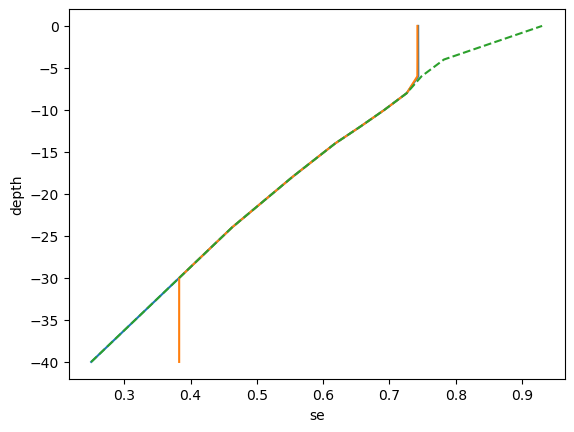

In [949]:
event_times = di_lin_ext.se.mean('depth') > 0.25

di_lin_ext.se.sel(time=event_times).mean('time').plot(y='depth')
di_val_ext.se.sel(time=event_times).mean('time').plot(y='depth')
di_lin_ext_sfcT_sfcice.se.sel(time=event_times).mean('time').plot(y='depth', ls='dashed')

In [950]:
dsc.depth

<xarray.DataArray 'depth' (depth: 10)>
array([-30., -24., -22., -18., -14., -12., -10.,  -8.,  -6.,  -4.])
Coordinates:
  * depth    (depth) float64 -30.0 -24.0 -22.0 -18.0 ... -10.0 -8.0 -6.0 -4.0

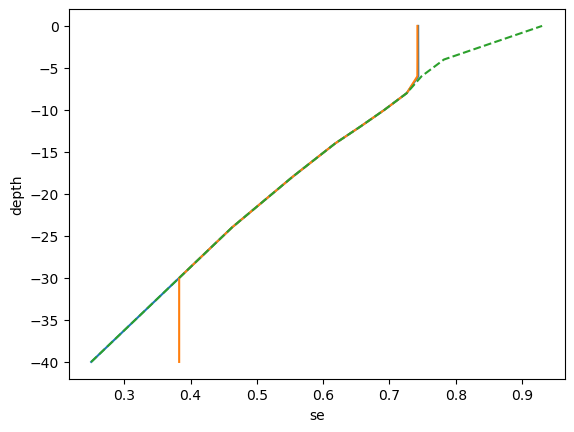

In [951]:
event_times = di_lin_ext.se.mean('depth') > 0.25

di_lin_ext.se.sel(time=event_times).mean('time').plot(y='depth')
di_val_ext.se.sel(time=event_times).mean('time').plot(y='depth')
di_lin_ext_sfcT_sfcice.se.sel(time=event_times).mean('time').plot(y='depth', ls='dashed')

In [952]:
np.nanmean((oht_lin_ext/oht_val_ext))

0.9692697176970847

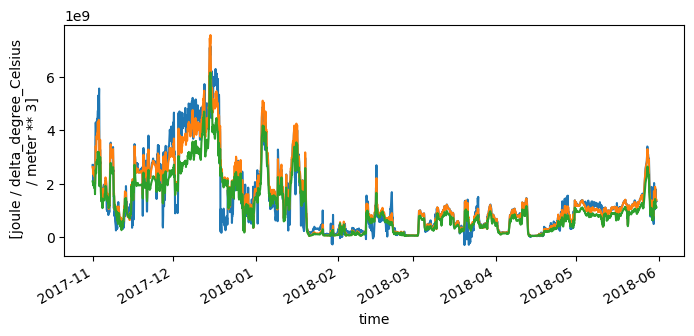

In [955]:
fig, ax = plt.subplots(figsize=(8,3))

# ohc_lin_ext.mean('depth').plot()
# ohc_val_ext.mean('depth').plot()

ohc_lin_ext.integrate('depth').plot()
ohc_val_ext.integrate('depth').plot()
ohc_lin_ext_sfcT.integrate('depth').plot()
# ohc_lin_ext_sfcT_sfcice.integrate('depth').plot()

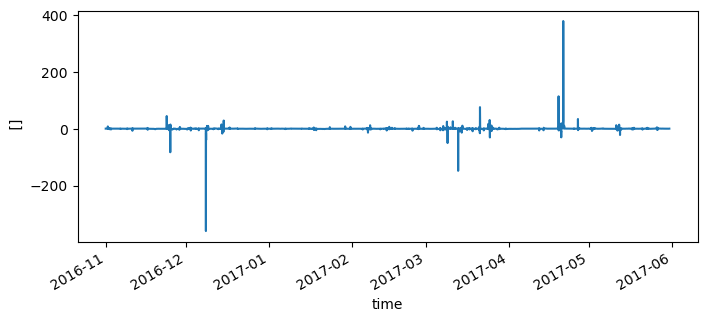

In [911]:
fig, ax = plt.subplots(figsize=(8,3))

# ohc_lin_ext.mean('depth').plot()
# ohc_val_ext.mean('depth').plot()

# oht_lin_ext.plot()
(oht_val_ext/oht_lin_ext_sfcT).plot()
# oht_lin_ext_sfcT.plot()


In [853]:
12/1.15

10.434782608695652

In [705]:
pd = (oht_lin_ext-oht_val_ext)/oht_val_ext

np.nanpercentile(abs(pd).sel(time=time_range2), 90)

0.49072477696771466

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 3.000e+00, 7.000e+00, 7.000e+00, 1.200e+01,
        3.300e+01, 1.771e+03, 1.706e+03, 4.200e+01, 1.100e+01, 9.000e+00,
        5.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00]),
 array([-20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
         -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
         13.,  14.,  15.,  16.,  17.,  18.,  19.]),
 <BarContainer object of 39 artists>)

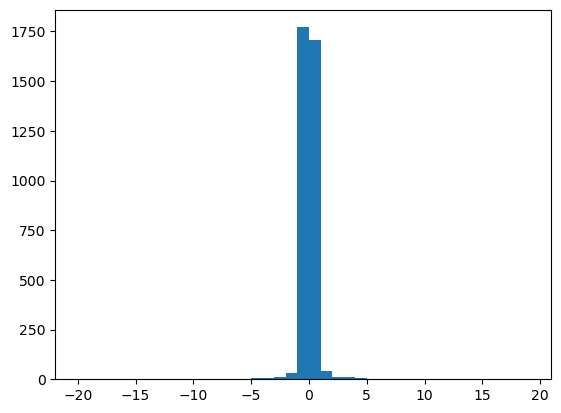

In [706]:
plt.hist(pd.sel(time=time_range2), bins=np.arange(-20,20,1))

(-1.0, 2.0)

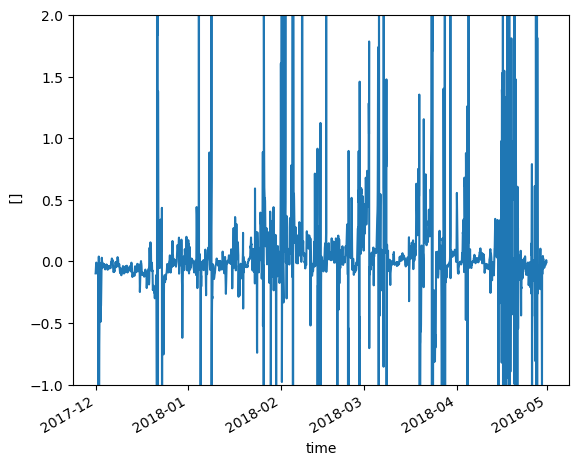

In [707]:
fig, ax = plt.subplots()
# ((oht_lin_ext-oht_val_ext)/oht_val_ext).plot()
(pd.sel(time=time_range2)).plot()
# (oht_val_ext).plot()

# (oht_lin_ext/oht_val_ext).plot()
ax.set_ylim(-1,2)

NameError: name 'u_sfc_shear' is not defined

In [1489]:
import h5py
f = h5py.File('/Users/mackenziejewell/Downloads/bg2324_mmp_d.mat','r')

variables = f.items()
for vv, var in enumerate(variables):
    name = var[0]
    data = var[1]
    print(f"[{vv}] {name}")  # Name
    

# Replace 'your_file.mat' with the actual path to your .mat file
df = sio.loadmat('/Users/mackenziejewell/Downloads/bg2324_mmp_d.mat')

OSError: Unable to synchronously open file (file signature not found)

In [1488]:
df

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Apr 10 18:30:26 2025',
 '__version__': '1.0',
 '__globals__': [],
 'DPDT': array([[-24.2021569 , -24.49106582, -24.39987999, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,  27.60684031,
          27.90141033,  27.36693212],
        [-22.38859526, -23.04761862, -23.61216295, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,  26.79437423,
          27.06083615,  26.83605221],
        [         nan,          nan,          nan, ..., -26.32381803,
         -25.74331174, -24.81974014],
        [         nan,          nan,          nan, ...,  25.86592984,
          25.93582781,  26.36018356]]),
 'P': array([[  42.13178962,   43.09228391,   44.05447871, ...,           nan,
                   nan,           nan],
        [          nan,           nan,           nan, ..., 1041.9999321

In [1475]:
df = pd.read_csv('/Users/mackenziejewell/Downloads/bg2324_bpr_d.dat', skiprows=[0,1], sep=' ')

dates = np.array([], dtype=np.datetime64) 

for date, time in zip(df['%date'].values[:-1], df['time(UTC)'].values[:-1]):
    
    timestr = str(int(time)).zfill(4)
    
    daytime = datetime.strptime(date+timestr, '%Y%m%d%H%M')

    dates = np.append(dates, daytime)
    
P = list(set(df['pressure(dbar)'].values))



In [1486]:
np.nanmin(np.array(P))

3588.674

In [1482]:
dates[:10]

array([datetime.datetime(2023, 10, 6, 23, 0),
       datetime.datetime(2023, 10, 6, 23, 15),
       datetime.datetime(2023, 10, 6, 23, 30),
       datetime.datetime(2023, 10, 6, 23, 45),
       datetime.datetime(2023, 10, 7, 0, 0),
       datetime.datetime(2023, 10, 7, 0, 15),
       datetime.datetime(2023, 10, 7, 0, 30),
       datetime.datetime(2023, 10, 7, 0, 45),
       datetime.datetime(2023, 10, 7, 1, 0),
       datetime.datetime(2023, 10, 7, 1, 15)], dtype=object)

In [1480]:
len(list((dates)))

33472

In [1479]:
len(list(set(dates)))

33472

In [1470]:

timestr = str(int(time)).zfill(4)

In [1471]:
datetime.strptime(date+timestr, '%Y%m%d%H%M')

datetime.datetime(2024, 9, 19, 14, 45)

In [1458]:
df

%date  time(UTC)  pressure(dbar)  temperature(C)
0       20231006     2300.0        3588.985         -0.2775
1       20231006     2315.0        3588.991         -0.2769
2       20231006     2330.0        3588.995         -0.2770
3       20231006     2345.0        3588.998         -0.2770
4       20231007        0.0        3589.002         -0.2768
...          ...        ...             ...             ...
33468   20240919     1400.0        3588.884         -0.2770
33469   20240919     1415.0        3588.872         -0.2770
33470   20240919     1430.0        3588.861         -0.2770
33471   20240919     1445.0        3588.851         -0.2772
33472  %endofdat        NaN             NaN             NaN

[33473 rows x 4 columns]

In [1455]:
len(list((df['pressure(dbar)'].values)))

33473

In [490]:
-0.11*16

-1.76

In [492]:
dso.Tf.sel(depth=-16).mean()

<xarray.DataArray 'Tf' ()>
array(-1.74515714)
Coordinates:
    depth    float64 -16.0

In [ ]:
-0.1 deg / meter

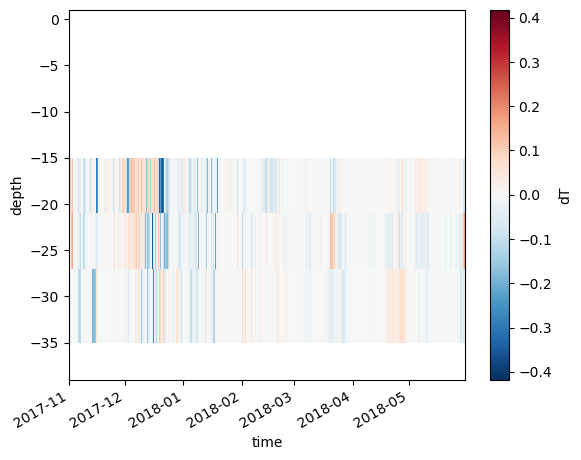

In [489]:
di.dT.plot()

<xarray.DataArray (depth: 3)>
array([-0.09124588, -0.1025534 , -0.09093795])
Coordinates:
  * depth    (depth) float64 -28.0 -22.0 -16.0

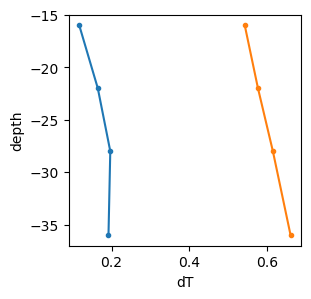

In [569]:
fig, ax = plt.subplots(figsize=(3,3))
event_times = dsc.se.sel(time=time_range2).mean('depth') > 0.25

# ax.set_xlim(-0.2,0)
(dso.dT.sel(time=time_range2).sel(time=(event_times==False)).mean('time')).plot(y='depth', marker='.')
(dso.dT.sel(time=time_range2).sel(time=event_times).mean('time')).plot(y='depth', marker='.')


16*dso.dT.sel(time=time_range2).sel(time=event_times).mean('time').diff('depth')/dso.depth.diff('depth')

<xarray.DataArray (depth: 3)>
array([-0.00570287, -0.00640959, -0.00568362])
Coordinates:
  * depth    (depth) float64 -28.0 -22.0 -16.0

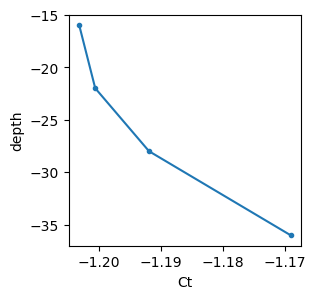

In [548]:
fig, ax = plt.subplots(figsize=(3,3))
event_times = dsc.se.sel(time=time_range2).mean('depth') > 0.25

# ax.set_xlim(-0.2,0)
# (dso.Ct.sel(time=time_range2).sel(time=(event_times==False)).mean('time')).plot(y='depth', marker='.')
(dso.Ct.sel(time=time_range2).sel(time=event_times).mean('time')).plot(y='depth', marker='.')


(dso.dT.sel(time=time_range2).sel(time=event_times).mean('time').diff('depth')/dso.depth.diff('depth'))

<xarray.DataArray (depth: 3)>
array([-0.00285548, -0.00144707, -0.00043044])
Coordinates:
  * depth    (depth) float64 -28.0 -22.0 -16.0

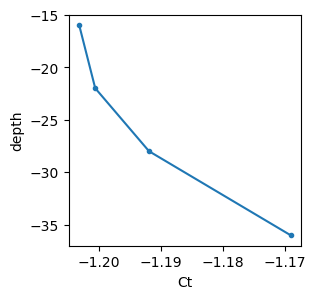

In [505]:
fig, ax = plt.subplots(figsize=(3,3))
event_times = dsc.se.sel(time=time_range2).mean('depth') > 0.25

# ax.set_xlim(-0.2,0)
# (dso.Ct.sel(time=time_range2).sel(time=(event_times==False)).mean('time')).plot(y='depth', marker='.')
(dso.Ct.sel(time=time_range2).sel(time=event_times).mean('time')).plot(y='depth', marker='.')


dso.Ct.sel(time=time_range2).sel(time=event_times).mean('time').diff('depth')/dso.depth.diff('depth')

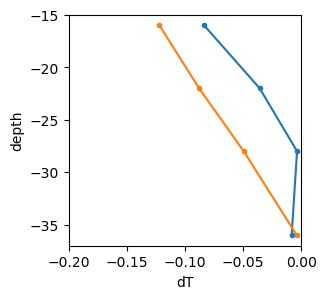

In [484]:
fig, ax = plt.subplots(figsize=(3,3))
event_times = dsc.se.sel(time=time_range2).mean('depth') > 0.25

ax.set_xlim(-0.2,0)

(dso.dT.sel(time=time_range2).sel(time=(event_times==False)).mean('time')-0.2).plot(y='depth', marker='.')
(dso.dT.sel(time=time_range2).sel(time=event_times).mean('time')-0.665).plot(y='depth', marker='.')
# dso.dT.sel(time=event_times).std('time').plot(y='depth', marker='.')

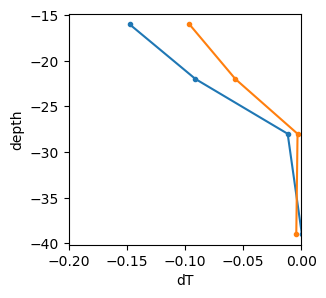

In [480]:
fig, ax = plt.subplots(figsize=(3,3))
event_times = dsc.se.sel(time=time_range2).mean('depth') > 0.25

ax.set_xlim(-0.2,0)

(dso.dT.sel(time=time_range2).sel(time=(event_times==False)).mean('time')-0.425).plot(y='depth', marker='.')
(dso.dT.sel(time=time_range2).sel(time=event_times).mean('time')-0.75).plot(y='depth', marker='.')

In [545]:

(dso.dT.sel(time=time_range2).sel(time=event_times).mean('time').diff('depth')/dso.depth.diff('depth'))

<xarray.DataArray (depth: 3)>
array([-0.00570287, -0.00640959, -0.00568362])
Coordinates:
  * depth    (depth) float64 -28.0 -22.0 -16.0

In [424]:
16 * (dso.dT.sel(time=event_times).mean('time').diff('depth') / dso.depth.diff('depth'))

<xarray.DataArray (depth: 3)>
array([-0.05822676, -0.07798732, -0.06937383])
Coordinates:
  * depth    (depth) float64 -28.0 -22.0 -16.0

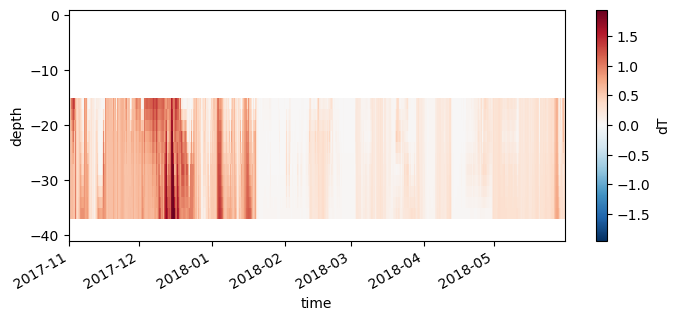

In [430]:
fig, ax = plt.subplots(figsize=(8,3))
di.dT.plot()

In [336]:

di_linear = di_base.interpolate_na(dim = 'depth', method='linear')



#====================
# BOUNDARY CONDITIONS
#====================

# ---------- extrapolate nearest values to surface/bottom ----------
di_ext = di.interpolate_na(dim = 'depth', method='nearest', fill_value = "extrapolate")

# ---------- linearly extrapolate to surface/bottom ----------
di_lin_ext = di.interpolate_na(dim = 'depth', method='linear', fill_value = "extrapolate")


mask = di_linear.isnull()
di_interp = di_linear.where(~mask, di_ext)

# ds2i = ds2i.interpolate_na(dim = 'depth', fill_value="extrapolate")


# ds_filled = ds.interpolate_na(dim='depth', method='nearest', fill_value="extrapolate")

In [337]:
di_lin_ext = di.interpolate_na(dim = 'depth', method='linear', fill_value = "extrapolate")



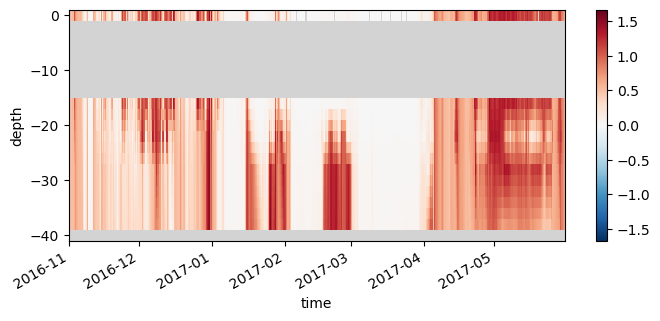

In [342]:
fig, ax = plt.subplots(figsize=(8,3))
ax.patch.set_facecolor('lightgray')

# (di_ext.Ct-di_ext.Tf).plot()
(di_base.Ct-di_base.Tf).plot()

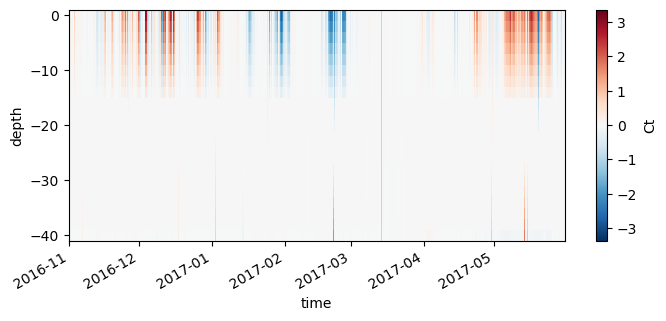

In [321]:
fig, ax = plt.subplots(figsize=(8,3))
ax.patch.set_facecolor('lightgray')
(di_lin_ext.Ct - di_ext.Ct).plot()

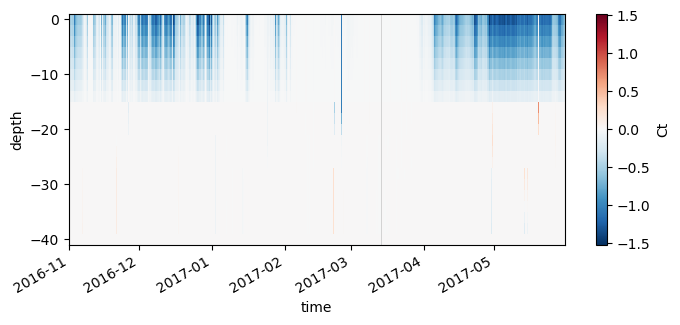

In [313]:
fig, ax = plt.subplots(figsize=(8,3))
ax.patch.set_facecolor('lightgray')
(di_interp.Ct - di_ext.Ct).plot()

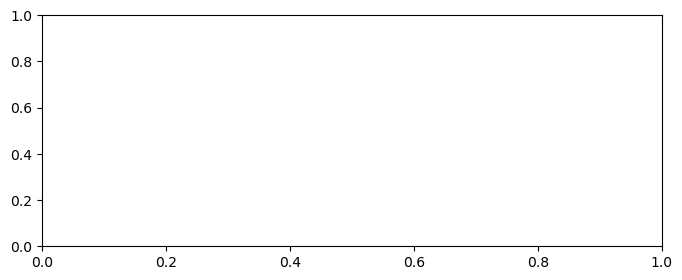

In [317]:
fig, ax = plt.subplots(figsize=(8,3))

DS = di_interp
dT = (DS['Ct']-DS['Tf']) * units('delta_degC')
rho = (di_ext['sig0']+1000) * units('kg/m3')
# rho = 1026 * units('kg/m3')

OHC_v1 = (cst['Cp_o'] * dT * rho).mean('depth')
OHC_v2 = (cst['Cp_o'] * dT * 1026).mean('depth')
# OHC_v1.plot()


# DS = di_ext
# dT = (DS['Ct']-DS['Tf']) * units('delta_degC')
# # rho = (di_ext['sig0']+1000) * units('kg/m3')
# rho = 1026 * units('kg/m3')

# OHC_v2 = (cst['Cp_o'] * dT * rho).mean('depth')

# (OHC_v1/OHC_v2).plot()

# (cst['Cp_o'] * dT * 1027).mean('depth').plot()

# ax.set_ylim(0,0.55e7)

In [ ]:
# considering rho variations results in mean difference of less than 1\%


In [318]:
np.nanmean((OHC_v1/OHC_v2).sel(time=slice(datetime(2016,12,1), datetime(2017,4,30))))

0.9989906850328838

In [307]:
np.nanmean(OHC_v1/OHC_v2)

0.8250185001673878

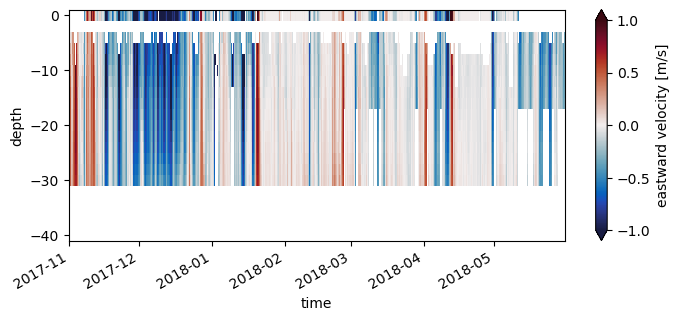

In [212]:
fig, ax = plt.subplots(figsize=(8,3))
di_base.u.plot(vmin=-1,vmax=1, cmap=cmocean.cm.balance)

# di_interp.Ct.plot(vmin=-2,vmax=0)
# di_interp.sig0.plot(vmin=22,vmax=28)

In [170]:
# ds2i['Ct'] = ds2i['Ct'].transpose(..., 'depth')  # Ensure depth is last for interpolate_na
# ds2i['Ct'] = ds2i['Ct'].interpolate_na(
#     dim='depth', method='linear', fill_value="extrapolate"
# )

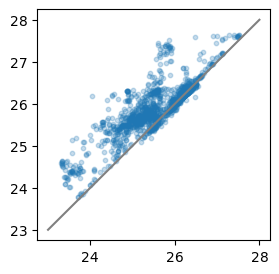

In [171]:
fig, ax = plt.subplots(figsize=(3,3))
ax.plot([23,28],[23,28], c='gray')
ax.scatter(ds2.sig0.sel(depth=-16).sel(time=event_times),
           ds2.sig0.sel(depth=-22).sel(time=event_times),
           s=10, alpha=0.25)

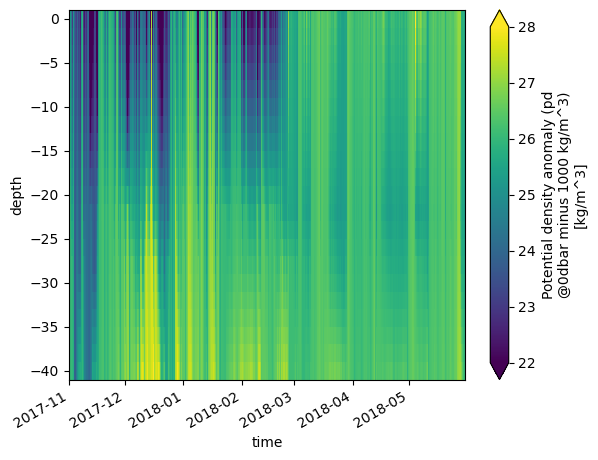

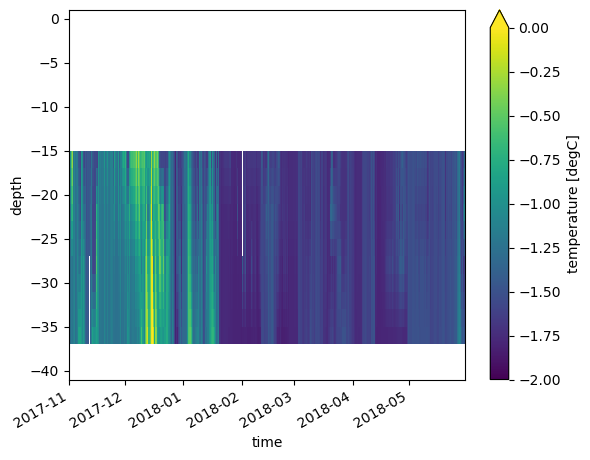

In [80]:
ds2i = ds2.interp(depth = d_depth)#.T.plot(vmin=-2,vmax=0)
ds2i.T.plot(vmin=-2,vmax=0)

In [81]:
event_times = (ds.u.mean('depth') < -0.25)#.time.values
event_times

<xarray.DataArray 'u' (time: 5064)>
array([False, False, False, ...,  True,  True,  True])
Coordinates:
  * time     (time) datetime64[ns] 2017-11-01 ... 2018-05-30T23:00:00

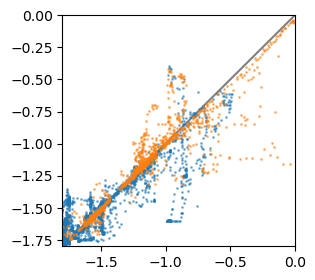

In [82]:
fig, ax = plt.subplots(figsize=(3,3))
ax.set_xlim(-1.8,0)
ax.set_ylim(-1.8,0)

ax.plot([-1.8,0],[-1.8,0], c='gray', zorder=-1)

ax.scatter(ds2i.T.sel(depth=-36).sel(time=(event_times==False)),
          ds2i.T.sel(depth=-28).sel(time=(event_times==False)), s=1, alpha=0.5)

ax.scatter(ds2i.T.sel(depth=-36).sel(time=event_times),
          ds2i.T.sel(depth=-28).sel(time=event_times), s=1, alpha=0.5)

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 5.000e+00, 2.000e+00, 0.000e+00, 4.000e+00, 3.000e+00,
        6.000e+00, 6.000e+00, 5.000e+00, 1.100e+01, 1.900e+01, 2.900e+01,
        4.500e+01, 6.700e+01, 8.600e+01, 1.630e+02, 2.270e+02, 6.520e+02,
        1.314e+03, 4.480e+02, 1.120e+02, 2.200e+01, 1.800e+01, 1.000e+01,
        1.000e+01, 9.000e+00, 4.000e+00, 5.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([-1.50000000e+00, -1.45000000e+00, -1.40000000e+00, -1.35000000e+00,
        -1.30000000e+00, -1.25000000e+00, -1.20000000e+00, -1.15000000e+00,
        -1.10000000e+00, -1.05000000e+00, -1.00000000e+00, -9.50000000e-01,
        -9.00000000e-01, -8.50000000e-01,

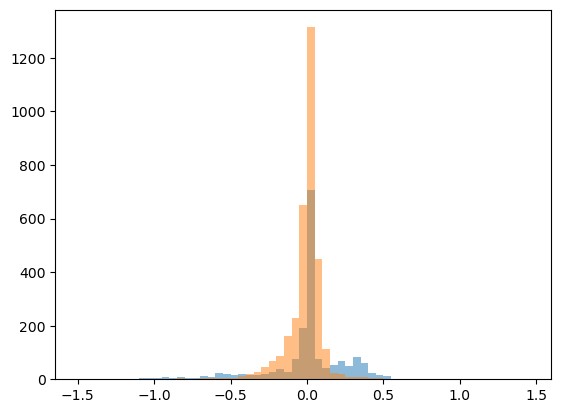

In [47]:
plt.hist(ds2.T.diff('depth').sel(depth=-16).sel(time=event_times), 
         bins=np.arange(-1.5,1.5,0.05), alpha=0.5)
plt.hist(ds2.T.diff('depth').sel(depth=-16).sel(time=(event_times==False)), 
         bins=np.arange(-1.5,1.5,0.05), alpha=0.5)


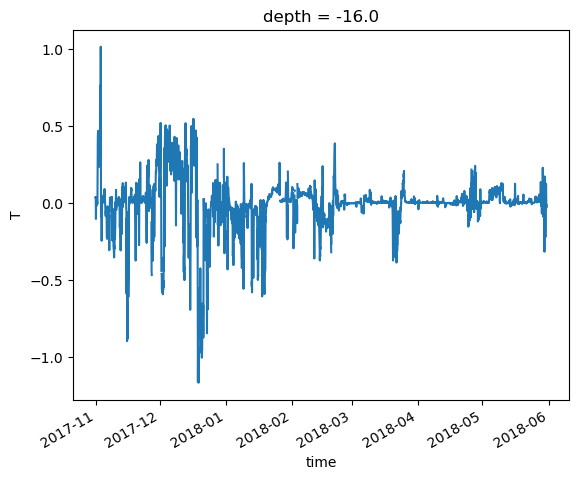

In [32]:
ds2.T.diff('depth').sel(depth=-16, time=event_times).plot()

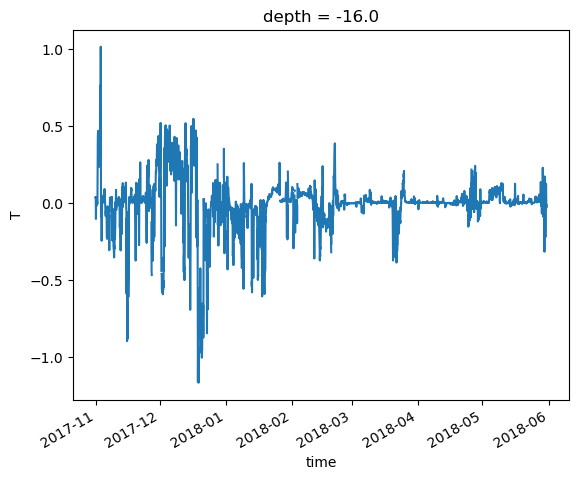

In [30]:
ds2.T.diff('depth').sel(depth=-16).plot()

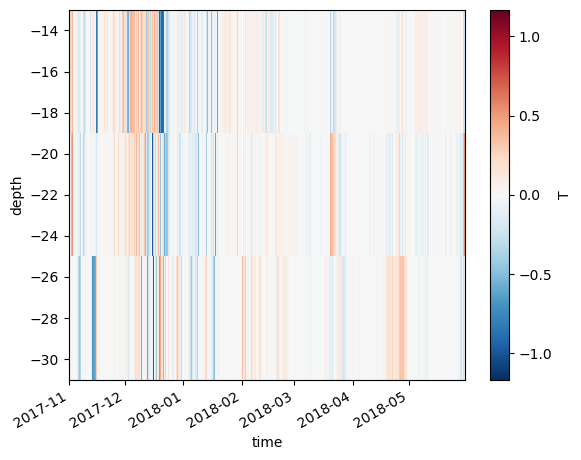

In [29]:
ds2.T.diff('depth').plot()

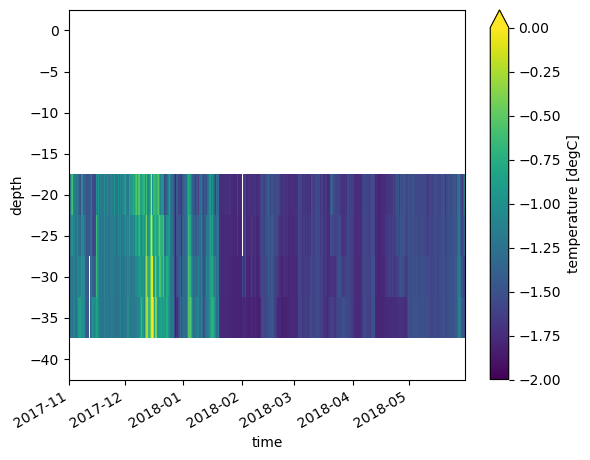

In [19]:
ds2.interp(depth = d_depth).T.plot(vmin=-2,vmax=0)

In [20]:
ds2.depth

<xarray.DataArray 'depth' (depth: 4)>
array([-36., -28., -22., -16.])
Coordinates:
  * depth    (depth) float64 -36.0 -28.0 -22.0 -16.0

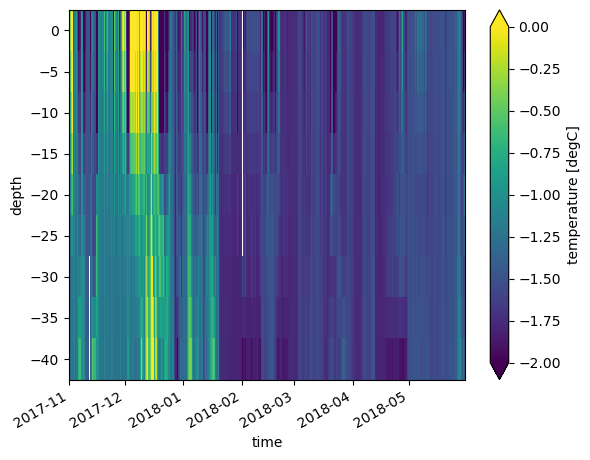

In [21]:
ds2.interp(depth = d_depth, kwargs={"fill_value": "extrapolate"}).T.plot(vmin=-2,vmax=0)

In [6]:
ds

<xarray.Dataset>
Dimensions:  (depth: 10, time: 5064)
Coordinates:
  * depth    (depth) float64 -30.0 -24.0 -22.0 -18.0 ... -10.0 -8.0 -6.0 -4.0
  * time     (time) datetime64[ns] 2017-11-01 ... 2018-05-30T23:00:00
Data variables:
    u        (depth, time) float64 0.3094 0.3182 0.3344 ... -0.325 -0.3345
    v        (depth, time) float64 -0.1048 -0.1008 -0.09802 ... 0.3209 0.2903
    se       (depth, time) float64 -0.3135 -0.3185 -0.3302 ... 0.4503 0.4405
    ne       (depth, time) float64 -0.09158 -0.09994 ... -0.07644 -0.04598
    speed    (depth, time) float64 0.3266 0.3338 0.3485 ... 0.4775 0.4568 0.4429
Attributes:
    lat:      69.7718
    lon:      -139.2582

### Evaluate data gaps

In [4]:
#===================
retain_frac = 0.95
#===================

print(f'Ocean currents:')
for depth in ds.depth.values[::-1]:
    # finite fraction
    ffrac = np.sum(np.isfinite(ds.u.sel(depth=depth).values)) / len(ds.time)
    print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')

print(f'\nOcean temperatures:')
for depth in ds2.depth.values[::-1]:
    # finite fraction
    ffrac = np.sum(np.isfinite(ds2.Ct.sel(depth=depth).values)) / len(ds2.time)
    print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
    
print(f'\nSea ice velocity:')
# finite fraction
ffrac = np.sum(np.isfinite(ds3.u.values)) / len(ds3.time)
print(f'z = {0} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')

Ocean currents:
z = -4.0 [0.54] 
z = -6.0 [0.79] 
z = -8.0 [0.91] 
z = -10.0 [0.96] *
z = -12.0 [0.96] *
z = -14.0 [0.95] *
z = -18.0 [0.91] 
z = -22.0 [0.00] 
z = -24.0 [0.84] 
z = -30.0 [0.99] *

Ocean temperatures:
z = -16.0 [1.00] *
z = -22.0 [1.00] *
z = -28.0 [1.00] *
z = -36.0 [0.99] *

Sea ice velocity:
z = 0 [0.85] 


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_43862/362214240.py:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_43862/362214240.py:15: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_43862/362214240.py:20: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {0} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')


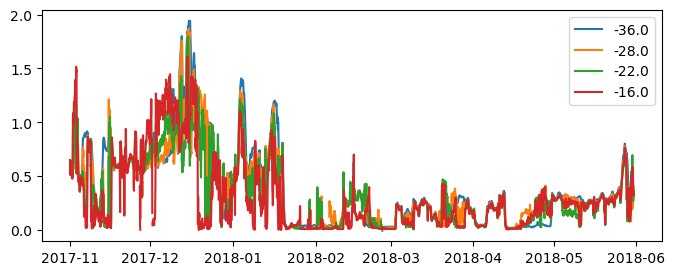

In [5]:
fig, ax = plt.subplots(figsize=(8,3))

for depth in ds2.depth.values:
    
    plt.plot(ds2.time, ds2.dT.sel(depth=depth), label=depth)
    
plt.legend()

In [6]:
np.arange(-170,-11,15)

array([-170, -155, -140, -125, -110,  -95,  -80,  -65,  -50,  -35,  -20])

In [7]:
%matplotlib notebook

In [8]:
fig, ax = plt.subplots(figsize=(3,3))


cond = (ds.se.mean(dim='depth') > 0.1) & (ds2.dT.sel(depth = -16) > 0.1)


for depth in ds2.depth.values[:-1]:
    ax.scatter(ds2.dT.sel(depth = -16)[cond], ds2.dT.sel(depth = depth)[cond], s=1 ,label=depth)
    
plt.legend()

<IPython.core.display.Javascript object>

In [9]:
for depth in ds2.depth.values:
    print(depth)

-36.0
-28.0
-22.0
-16.0


In [10]:
fig, ax = plt.subplots(figsize=(8,3))

# ax.axhline(30, c='k', lw=0.5)
# ax.plot(ds3.time, ds3.se + 30, c='k', label=f'ice se')

yy = 1
ax.axhline(yy, c='k', lw=0.5)
ax.bar(DS.time, DS.extent/1000, align='edge', bottom = yy)

# for depth in ds.depth.values[::-1][:10]:
#     ax.plot(ds.time, ds.se.sel(depth = depth)-ds.se.sel(depth = -7.3), label=f'{depth} m')
    
for depth in ds2.depth.values[::-1]:
    ax.plot(ds2.time, ds2.dT.sel(depth = depth), label=f'{depth} m')
    
    
# ax.plot(ds.time, ds3.se-ds.se.sel(depth = -7.3), c='gray')
# ax.plot(ds.time, ds3.se, c='k')

# plt.pcolormesh(ds2.time, ds2.depth[:-1], ds2.sig0.diff('depth') / ds2.depth.diff('depth'), vmin=-0.25, vmax=0.25, cmap=cmocean.cm.balance)
    
ax.plot(ds.time, ds.se.mean(dim='depth'), c='k')


plt.legend(bbox_to_anchor=(1,1))

# plt.ylim(-2,2)
# plt.ylabel('sig0 (kg/m3)')
# plt.title(mooring)



<IPython.core.display.Javascript object>

# Interpolate / Extrapolate velocities

In [11]:
def time_interp(time, data, max_interp):
    
    # time - interp
    data_interp, dt_interp = tseries.linear_interpolate(og_times, og_times, data, max_dt = max_interp)

    return data_interp


def interp_z(z_vals, og_times, data_grid, og_data, og_z, need_interp_z):
    
    d_grid = np.copy(data_grid)
    
    for zz in need_interp_z:
        
        print(zz)

        # find index
        zi = np.where(z_vals == zz)[0][0]

        # find nan times
        iter_tt = np.arange(len(og_times))[np.isnan(d_grid[zi,:])]

        for tt in iter_tt:

            non_nan_zs = og_z[np.isfinite(og_data[:,tt])]
            
            # identify closest non-nan depths above and below
#             non_nan_zs = z_vals[np.isfinite(d_grid[:,tt])]

            if len(non_nan_zs) > 0:
                
                if np.sum(non_nan_zs < zz) > 0 and np.sum(non_nan_zs > zz) > 0:

                    z_abv = non_nan_zs[non_nan_zs > zz].min()
                    z_blw = non_nan_zs[non_nan_zs < zz].max()

                    # grab their indices
                    zi_abv = np.where(og_z == z_abv)[0][0]
                    zi_blw = np.where(og_z == z_blw)[0][0]

                    # interp the values across gap
                    duT = og_data[zi_abv, tt]-og_data[zi_blw, tt]
                    dzT = z_abv-z_blw

                    dzt = zz-z_blw

                    d_grid[zi, tt] = og_data[zi_blw, tt] + dzt*(duT/dzT)

    return d_grid
        
    
    
    
def handle_sfc_nans(og_times, data_grid, method = 'extend'):
    
    zz = z_vals.max() 
    zi0 = np.where(z_vals == zz)[0][0]

    # find nan times
    iter_tt = np.arange(len(og_times))[np.isnan(data_grid[zi0,:])]
    
    for tt in iter_tt:
        
        # identify closest non-nan depths below
        non_nan_zs = z_vals[np.isfinite(data_grid[:,tt])]
        
        # identify closest non-nan depth below
        z_blw = non_nan_zs[non_nan_zs < zz].max()
        zi_blw = np.where(z_vals == z_blw)[0][0]
        
        if str(method) == 'extend':
            # replace surface layer with value at given layer
            data_grid[zi0,tt] = data_grid[zi_blw, tt]
            
        elif str(method) == 'extrapolate':
            # identify 2nd closest non-nan depth below
            z2_blw = non_nan_zs[non_nan_zs < z_blw].max()
            z2i_blw = np.where(z_vals == z2_blw)[0][0]

            # change across defined values
            dz_d = z_blw - z2_blw
            dv_d = data_grid[zi_blw, tt] - data_grid[z2i_blw, tt]
            
            # change across desired range
            dz_u = zz - z2_blw

            # extraploate to final point
            dv_u = dz_u * (dv_d/dz_d)
            
            data_grid[zi0,tt] = dv_u + data_grid[z2i_blw, tt]
            
    return data_grid
            
    
    
def identify_matching_layers(og_data, z_vals, addressed_z):

    # identify exact matching z and those that need interp
    exact_z = []
    need_interp_z = []
    for zi, zz in enumerate(z_vals):
        if zz not in addressed_z:

            if zz in og_z:
                num_nonnan = np.sum(np.isfinite(og_data.sel(depth=zz).values))

                if num_nonnan > 0:
                    exact_z.append(zz)
                else:
                    need_interp_z.append(zz)
            else:
                need_interp_z.append(zz)
                
    return exact_z, need_interp_z


def copy_matching_layers(data_grid, og_data, z_vals, exact_z, max_interp):
    

    # sub in existing ocean currents if direct match
    for zz in exact_z:

        # find index
        zi = np.where(z_vals == zz)[0][0]

        # find og vals
        og_val = og_data.sel(depth=zz).values

        # time-interpolate ice velocities to remove small gaps
        data_grid[zi, :] = time_interp(og_times, og_val, max_interp)

        print(f'z = {zz}: * matching o')
        
    return data_grid
#         addressed_z.append(zz)

#     for zz in need_interp_z:
#         print(f'z = {zz}: -needs interp:')




def handle_bottom_nans(data_grid, og_data, z_vals,  og_times, og_z, max_interp, method = 'extend'):
    
    # (2a) extend lowest velocities across bottom
    #--------------------------------------------
    
    # indices to address
#     zi_s = np.arange(len(z_vals))[z_vals < lowest_z]
    
    if str(method) == 'extend':

        # grab lowest velocity
        data_val = np.array([])
        lowest_zs_used = np.array([])
        
        for time in og_times:
            
            og_crop = og_data.sel(time = time)
            
            low_z = og_z[np.isfinite(og_crop.values)]
            
            if len(low_z) > 0:
                lowest_z = low_z.min()
                lowest_zs_used = np.append(lowest_zs_used, lowest_z)
                data_val = np.append(data_val, og_data.sel(time = time).sel(depth=lowest_z).values  )
            else:
                lowest_zs_used = np.append(lowest_zs_used, np.nan)
                data_val = np.append(data_val, np.nan)
            
#         data_val = og_data.sel(depth=lowest_z).values

        # time-interpolate ice velocities to remove small gaps
        data_interp = time_interp(og_data, data_val, max_interp)

        for tt in range(len(og_times)):
            
            if np.isfinite(lowest_zs_used[tt]):
                zi_max = np.where(z_vals < lowest_zs_used[tt])[0][-1]
                data_grid[:zi_max+1, tt] = data_interp[tt]

            
#             zi_s = [z_vals[z_vals < lowest_z].min() for lowest_z in lowest_zs_used[tt]]

#             for zi in zi_s:

#                 zz = z_vals[zi]

#                 print(f'z = {zz} : {method}')

#                 data_grid[zi, :] = data_interp

    
    elif str(method) == 'extrapolate':
        
        lowest_zs_used = []
        
        for zi in zi_s:

            zz = z_vals[zi]
            
            print(f'z = {zz} : {method}')
            
            for tt in np.arange(len(og_times)):

                # identify closest non-nan depths above
                non_nan_zs = z_vals[np.isfinite(data_grid[:,tt])]

                z_abv = non_nan_zs[non_nan_zs > zz].min()
                zi_abv = np.where(z_vals == z_abv)[0][0]

                # identify 2nd closest non-nan depth above
                z2_abv = non_nan_zs[non_nan_zs > z_abv].min()
                z2i_abv = np.where(z_vals == z2_abv)[0][0]

                # change across defined values
                dz_d = z_abv - z2_abv
                dv_d = data_grid[zi_abv, tt] - data_grid[z2i_abv, tt]

                # change across desired range
                dz_u = zz - z2_abv

                # extraploate to final point
                dv_u = dz_u * (dv_d/dz_d)

                data_grid[zi,tt] = dv_u + data_grid[z2i_abv, tt]

    
    return data_grid, lowest_zs_used

    

In [12]:
# J m-2 s-1

# Cp * dt * sig0 * u 



# A = 10000*40

# J s-1

# Cp * dt * sig0 * u * A
    # dss = ds2
    # og_data = dss['Tf'] 

    # dss = ds2
    # og_data = dss['Ct'] 

    # dss = ds2
    # og_data = dss['Sp'] 

    # dss = ds2
    # og_data = 1000+dss['sig0']

    # og data
    # dss = ds
    # og_data = dss['u']

    # dss = ds
    # og_data = dss['v']





In [ ]:

labels = ['Tf', 'Ct', 'Sp', 'sig0', 'u', 'v']
datsts = [ds2, ds2, ds2, ds2, ds, ds]
addons = [0, 0, 0, 1000, 0, 0]


long_names = ['Freezing temperature', 'Conservative temperature', 
              'Seawater density', 'Practical salinity', 
              'Eastward velocity', 'Northward velocity']
all_units = ['degC', 'degC', 'kg/m3', 'psu', 'm/s', 'm/s']


all_data = {}

for lab, dss, add in zip(labels, datsts, addons):

    
    #=========================
    # og data
#     dss = dss
    og_data = add+dss[lab]

    # specify surface conditions
    og_sfc =  np.full(len(dss.time), np.nan)
    # og_sfc =  ds3['v']
    sfc_method = 'extend'

    # specify bottom conditions
    og_bot =  np.full(len(dss.time), np.nan)
    bottom_method = 'extend'

    # max time gap allowed in time interp
    max_interp = 6 * units('hour')

    # new z vals
    z_vals = np.linspace(-40,0,21)
    # z_vals = np.arange(-165,-29,15)
    # z_vals = np.arange(-170,-11,15)
    #=========================

    # time-interpolate surface velocities to remove small gaps
    # sfc_interp = time_interp(og_times, og_sfc, max_interp)
    # data_grid[zi, :] = sfc_interp


    # og grids
    og_times = pd.to_datetime(dss.time)
    og_z = np.copy(dss.depth.values)

    # start empty grid
    data_grid = np.full((len(z_vals), len(dss.time)), np.nan)

    # add in top and bottom values as specified
    data_grid[-1,:] = og_sfc
    data_grid[0,:] = og_bot

    addressed_z = []



    # Directly copying matching layers
    #======================================================
    print(f'\nMiddle layers handling : copy matching layers')
    exact_z, need_interp_z = identify_matching_layers(og_data, z_vals, addressed_z)
    data_grid = copy_matching_layers(data_grid, og_data, z_vals, exact_z, max_interp)


    # Interp where data exist
    #======================================================
    # first just for missing layers
    data_grid = interp_z(z_vals, og_times, data_grid, og_data, og_z,  need_interp_z)

    # Handling the bottom
    #======================================================
    # find lowest velocities
    print(f'\nBottom boundary handling :')
    data_grid, lowest_zs_used = handle_bottom_nans(data_grid, og_data, z_vals, 
                                   og_times,og_z, max_interp, method = bottom_method)




    # Handling the surface
    #======================================================
    # find index of surface
    # zi = np.where(z_vals == 0)[0][0]
    data_grid = handle_sfc_nans(og_times, data_grid, method = sfc_method)

    print(f'\nTop boundary handling :')
    print(f'z = {0}: * matching surface')
    # addressed_z.append(z_vals[zi])


    # (5) Handling missing data in surface-most layer
    #======================================================
    # extend nearest-to-sfc. values to the surface
    # find index of surface-most layer
    # data_grid = handle_sfc_nans(og_times, data_grid, method = sfc_method)


    # (6) Handling missing data in middle layers
    #======================================================    
    # then once more across all layers to fill gaps
    # fill from newly-filled grid
    data_grid = interp_z(z_vals, og_times, data_grid, data_grid, z_vals,  z_vals[z_vals!=0])


    all_data[lab] = data_grid


Middle layers handling : copy matching layers
z = -36.0: * matching o
z = -28.0: * matching o
z = -22.0: * matching o
z = -16.0: * matching o
-40.0
-38.0
-34.0


In [ ]:
data_vars = {}
for lab, long_name, unit in zip(labels, long_names, all_units):
    data_vars[lab] = (("z","time"), all_data[lab], {'long_name': long_name, 'units': unit})

coords={"time": dss.time.values, "z": z_vals}

dsc = xr.Dataset(data_vars, coords=coords, 
                attrs={'description':'regridded variables needed in OHT. Extend V, T, S, Sig values to sfc/bottom. Extend highest currents to surface, and extend lowest currents to bottom.',})


<IPython.core.display.Javascript object>


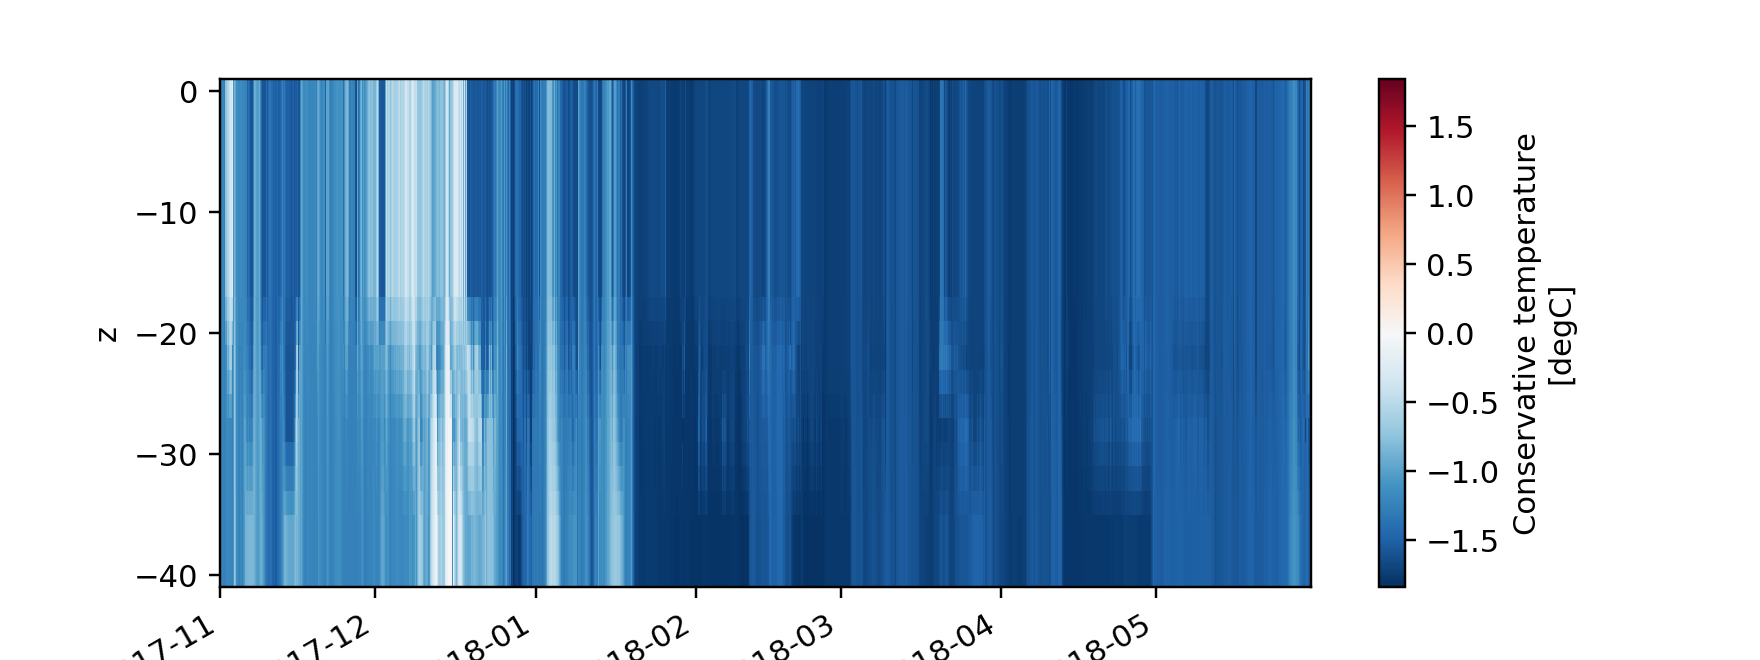

In [15]:
fig, ax = plt.subplots(figsize=(8,3))
dsc.Ct.plot()

In [16]:
# save to file
mainpath = f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/regridded/'
filename = f"{mooring}_OHT_{open_years}_v1.nc"
dsc.to_netcdf(mainpath+filename)


In [77]:
# data_vars = {}
# data_vars[f'Tf'] = (("z","time"),Tf_grid, {'long_name': 'Freezing temperature', 'units': 'degC'})
# data_vars[f'CT'] = (("z","time"), CT_grid, {'long_name': 'Conservative temperature', 'units': 'degC'})
# data_vars[f'sig0'] = (("z","time"), Sig_grid, {'long_name': 'seawater density', 'units': 'kg/m3'})
# data_vars[f'Sp'] = (("z","time"), Sp_grid, {'long_name': 'Practical salinity', 'units': 'psu'})
# data_vars[f'u'] = (("z","time"), u_grid, {'long_name': 'eastward velocity', 'units': 'm/s'})
# data_vars[f'v'] = (("z","time"), v_grid, {'long_name': 'northward velocity', 'units': 'm/s'})

# coords={"time": dss.time.values, "z": z_vals}

# dsc = xr.Dataset(data_vars, coords=coords, 
#                 attrs={'description':'regridded variables needed in OHT. Extend V, T, S, Sig values to sfc/bottom. Extend highest currents to surface, and extend lowest currents to bottom.',})


# # save to file
# mainpath = f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/regridded/'
# filename = f"{mooring}_OHT_{open_years}_v1.nc"
# dsc.to_netcdf(mainpath+filename)


<IPython.core.display.Javascript object>


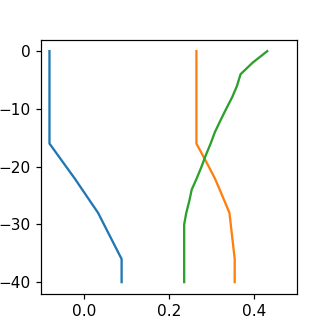

(-0.1, 0.5)

In [190]:
fig, ax = plt.subplots(figsize=(3,3))
plt.plot((np.mean(S_grid, axis=1)-1026)/5, z_vals)
plt.plot(np.mean(T_grid, axis=1), z_vals)
# plt.plot(np.mean(np.sqrt(u_grid**2+v_grid**2), axis=1), z_vals)
plt.plot(np.mean(np.sqrt(u_grid**2+v_grid**2), axis=1), z_vals)

plt.xlim(-0.1,0.5)

<IPython.core.display.Javascript object>


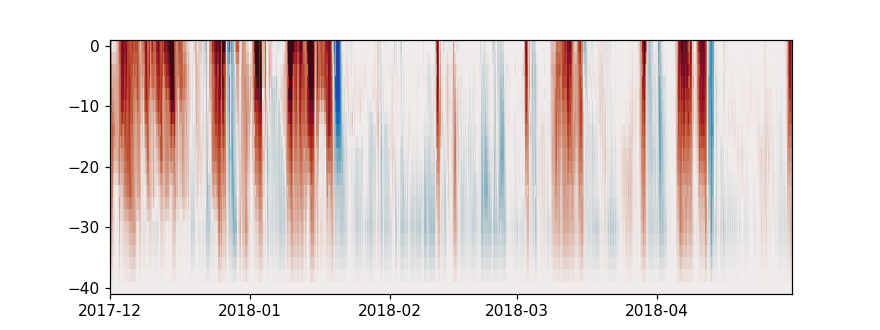

<IPython.core.display.Javascript object>


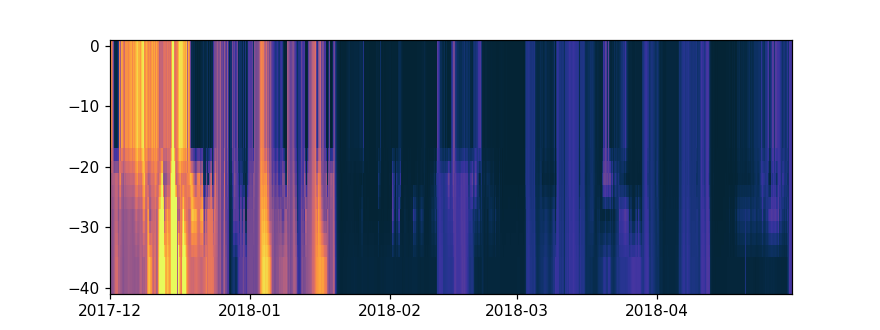

<IPython.core.display.Javascript object>


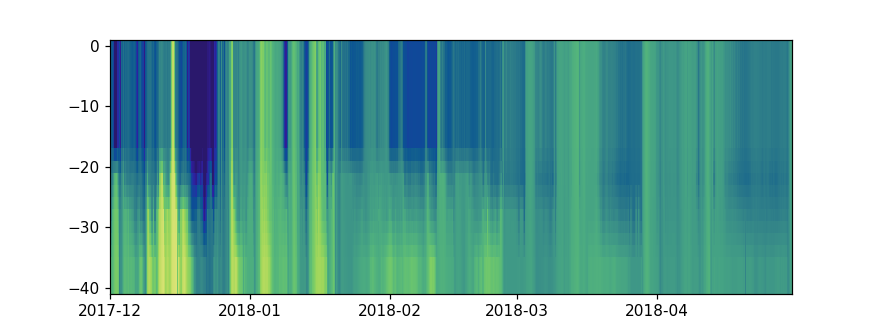

In [156]:
fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, v_grid_v2, cmap=cmocean.cm.balance, vmin=-1, vmax=1)

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, T_grid, cmap=cmocean.cm.thermal, vmin=0, vmax=1.5)

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, S_grid-1000, cmap=cmocean.cm.haline, vmin=24, vmax=28)


<IPython.core.display.Javascript object>


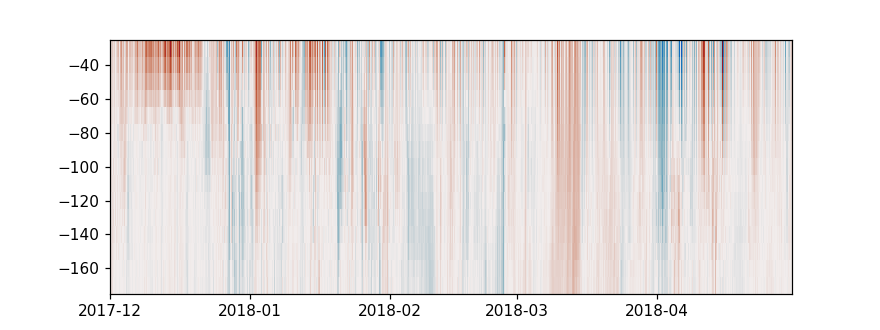

<IPython.core.display.Javascript object>


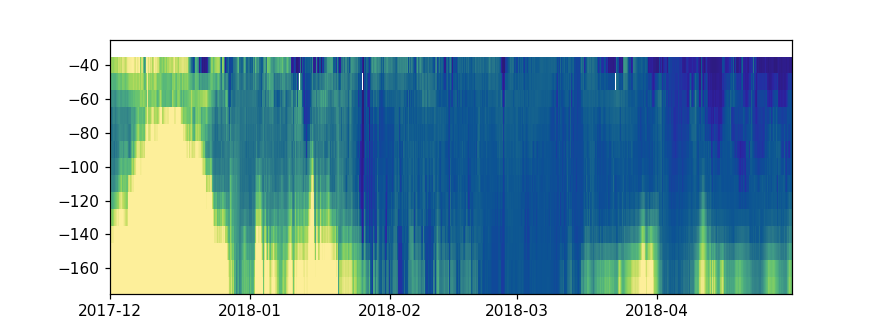

In [29]:
fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, data_grid, cmap=cmocean.cm.balance, vmin=-1, vmax=1)

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, data_grid2, cmap=cmocean.cm.haline, vmin=0, vmax=1500)


In [170]:
u_grid = v_grid_v2 * units('m/s')
ts_grid = S_grid*T_grid * units('delta_degC kg/m3')

hf = cst['Cp_o'] * u_grid * ts_grid

# positive-only heat flux
phf = np.copy(hf)
phf[phf<0* hf.units] = 0 * hf.units

cumH = np.cumsum(np.nansum(hf, axis=0) * 1 * units('hour').to('s')) * 2*units('m') * 20*units('km').to('m')
cumH

<Quantity([3.47494873e+15 6.93020553e+15 1.03086800e+16 ... 2.33265515e+18
 2.33388050e+18 2.33514749e+18], 'joule')>

<IPython.core.display.Javascript object>


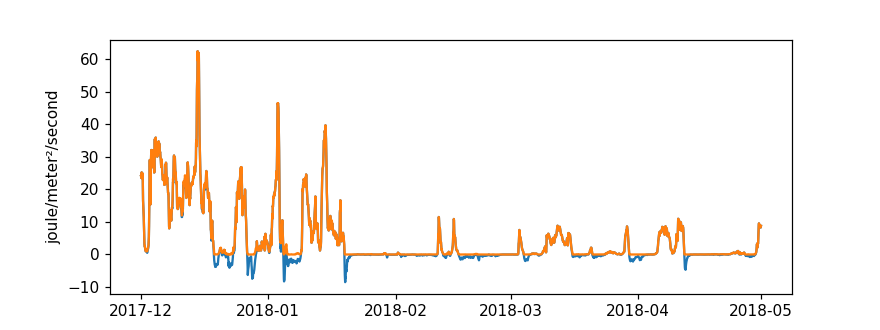

<IPython.core.display.Javascript object>


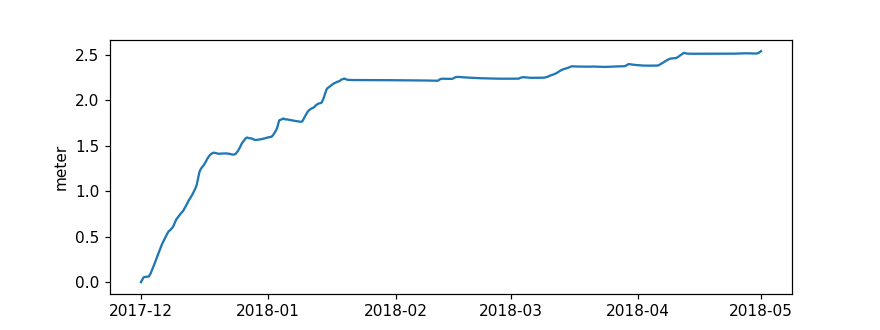

In [175]:
fig, ax = plt.subplots(figsize=(8,3))

plt.plot(dss.time, np.nansum(hf, axis=0)/1000000)
plt.plot(dss.time, np.nansum(phf, axis=0)/1000000)
# plt.bar(DS.time, DS.extent.values/1000, color='k')

fig, ax = plt.subplots(figsize=(8,3))
plt.plot(dss.time, (cumH/(cst['L_i'] * cst['rho_i']*(30*units('km').to('m'))*(100*units('km').to('m')))).to('m'))


In [30]:
u_grid = data_grid * units('m/s')
ts_grid = data_grid2 * units('delta_degC kg/m3')

hf = cst['Cp_o'] * u_grid * ts_grid

# positive-only heat flux
phf = np.copy(hf)
phf[phf<0* hf.units] = 0 * hf.units

In [21]:
# data_grid2 = data_grid

<IPython.core.display.Javascript object>


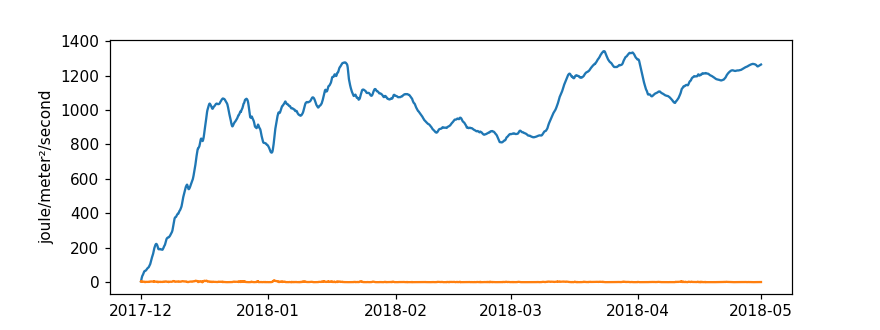

In [55]:
fig, ax = plt.subplots(figsize=(8,3))

plt.plot(dss.time, np.cumsum(np.nansum(hf, axis=0))/1000000)
plt.plot(dss.time, np.nansum(phf, axis=0)/1000000)
# plt.bar(DS.time, DS.extent.values/1000, color='k')


In [77]:
cumH = np.cumsum(np.nansum(hf, axis=0) * 1 * units('hour').to('s')) * 10*units('m') * 30*units('km').to('m')
cumH

<Quantity([4.66068175e+15 1.07019902e+16 1.58550775e+16 ... 1.36414703e+18
 1.36520175e+18 1.36589305e+18], 'joule')>

<IPython.core.display.Javascript object>


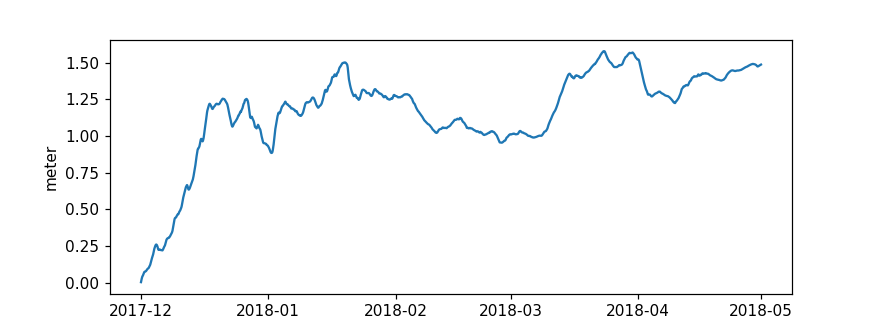

In [79]:
fig, ax = plt.subplots(figsize=(8,3))
plt.plot(dss.time, (cumH/(cst['L_i'] * cst['rho_i']*(30*units('km').to('m'))*(100*units('km').to('m')))).to('m'))

In [ ]:
cst['L_i'] * cst['rho_i']

<IPython.core.display.Javascript object>


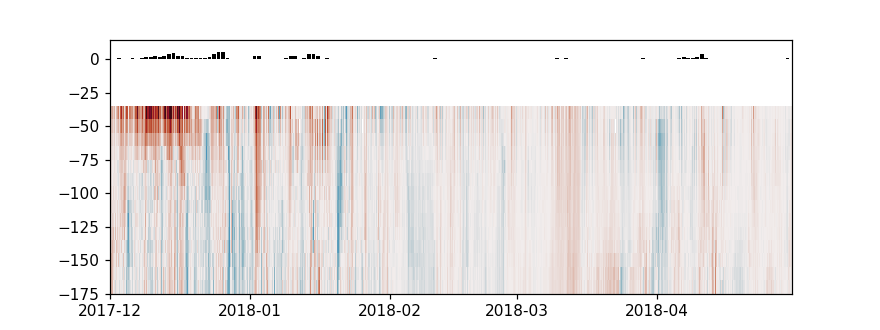

<BarContainer object of 151 artists>

In [50]:

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, hf, cmap=cmocean.cm.balance, vmin=-2000000, vmax=2000000)
plt.bar(DS.time, DS.extent/1000, color='k')

<IPython.core.display.Javascript object>


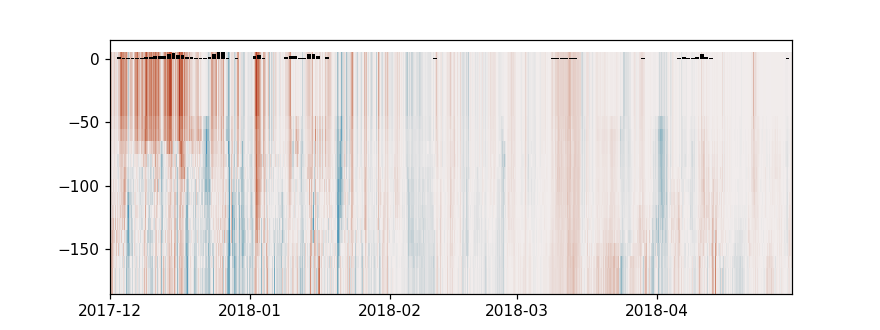

<BarContainer object of 151 artists>

In [199]:

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, hf, cmap=cmocean.cm.balance, vmin=-2000000, vmax=2000000)
plt.bar(DS.time, DS.extent/1000, color='k')

In [229]:
z_vals[-10:-5]

array([-90, -80, -70, -60, -50])

In [240]:
z_vals[-18:-13]

array([-170, -160, -150, -140, -130])

<IPython.core.display.Javascript object>


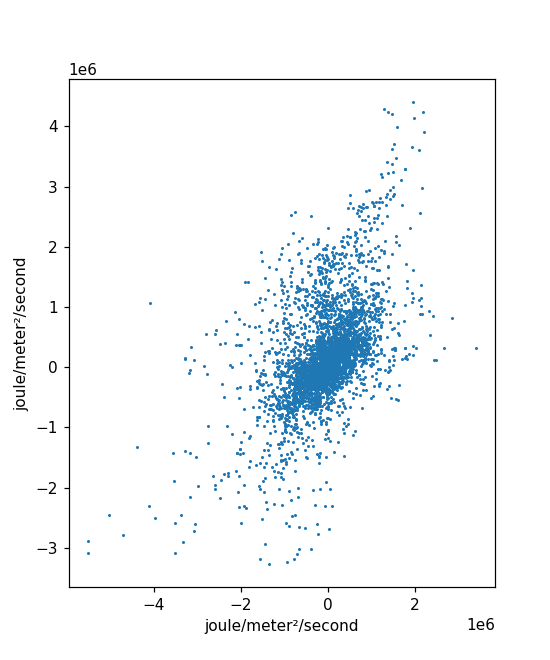

In [241]:
fig, ax = plt.subplots(figsize=(5,6))

plt.scatter(np.sum(hf[-18:-13, :], axis=0), np.sum(hf[-10:-5,:], axis=0), s=1)

<IPython.core.display.Javascript object>


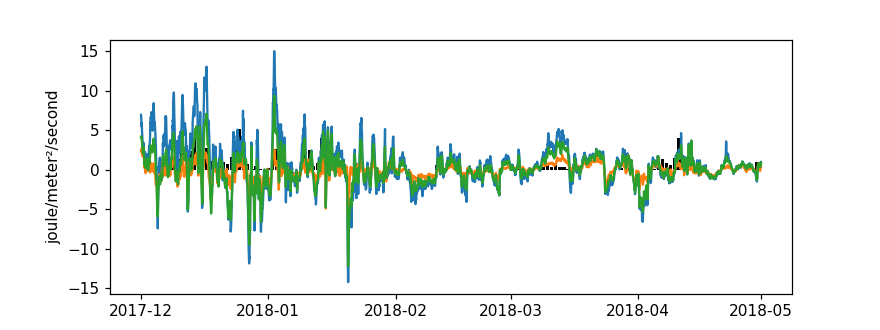

In [220]:
fig, ax = plt.subplots(figsize=(8,3))
plt.bar(DS.time, DS.extent.values/1000, color='k')
plt.plot( dss.time, np.sum(hf, axis=0)/1000000)
plt.plot( dss.time, np.sum(hf[:-13,:], axis=0)/1000000)
plt.plot( dss.time, np.sum(hf[:-5,:], axis=0)/1000000)

<IPython.core.display.Javascript object>


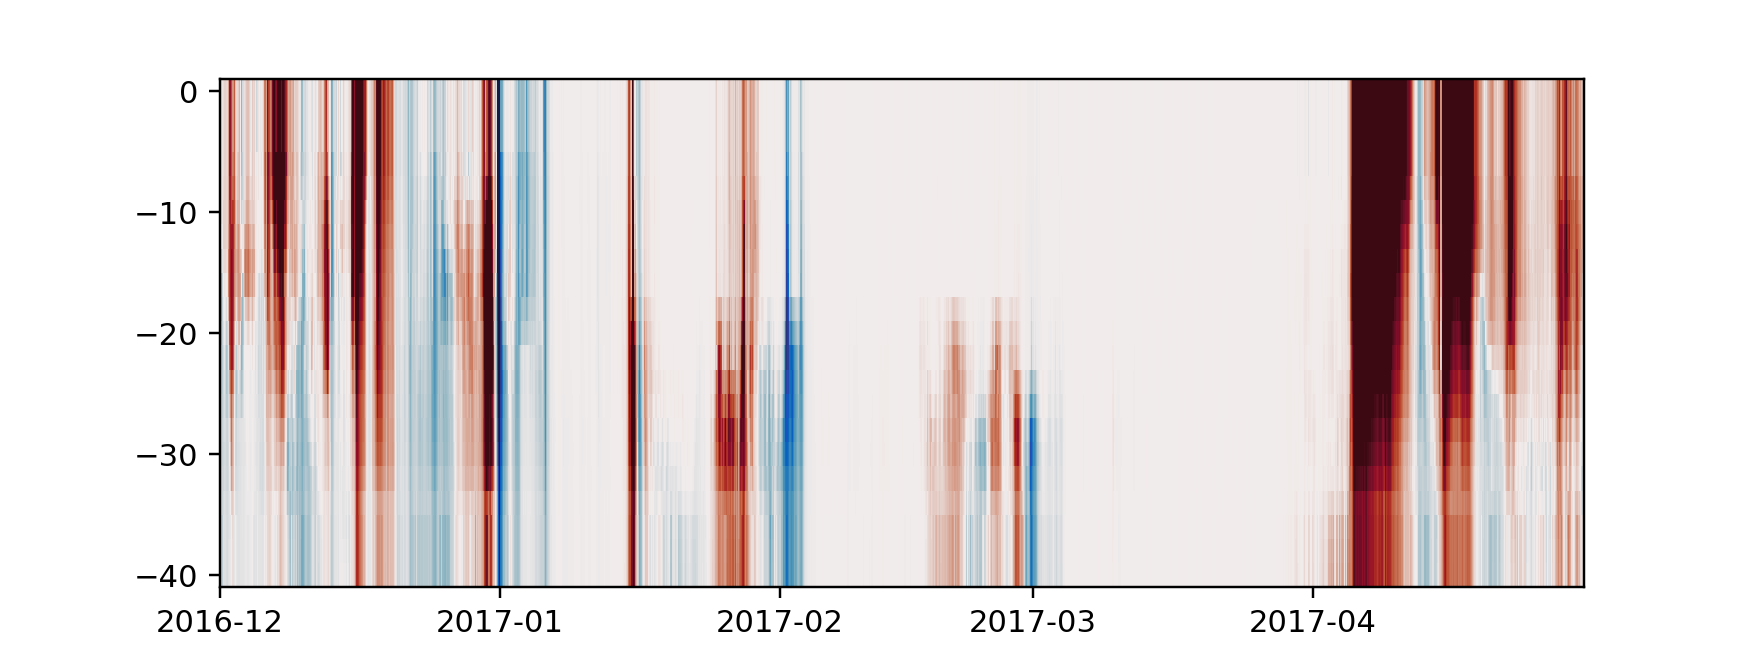

In [136]:

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, hf, cmap=cmocean.cm.balance, vmin=-2000000, vmax=2000000)
# plt.contour( dss.time, z_vals, ts_grid, levels=[500], colors=['gold'])


<IPython.core.display.Javascript object>


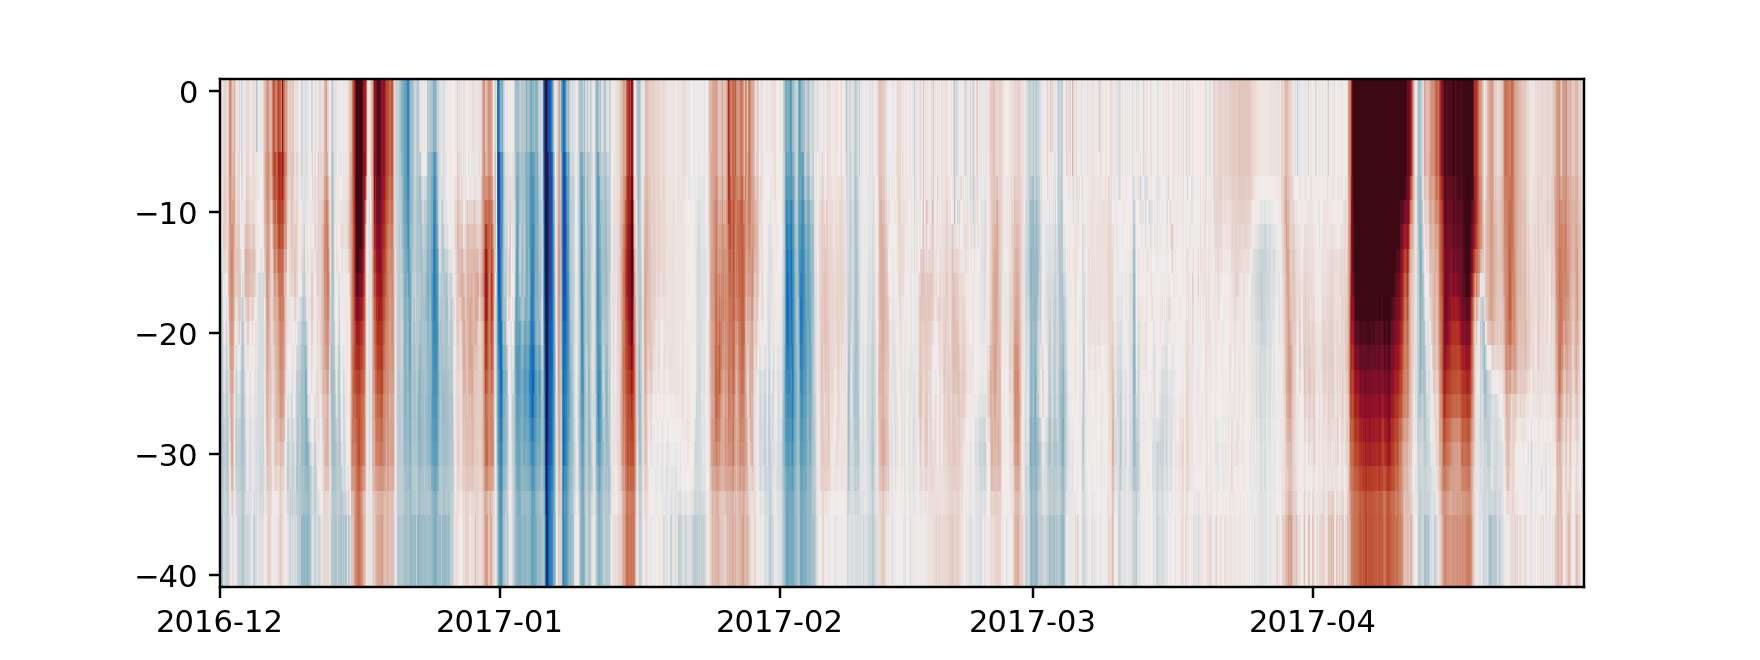

In [130]:

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, data_grid2, cmap=cmocean.cm.balance, vmin=-1, vmax=1)


<IPython.core.display.Javascript object>


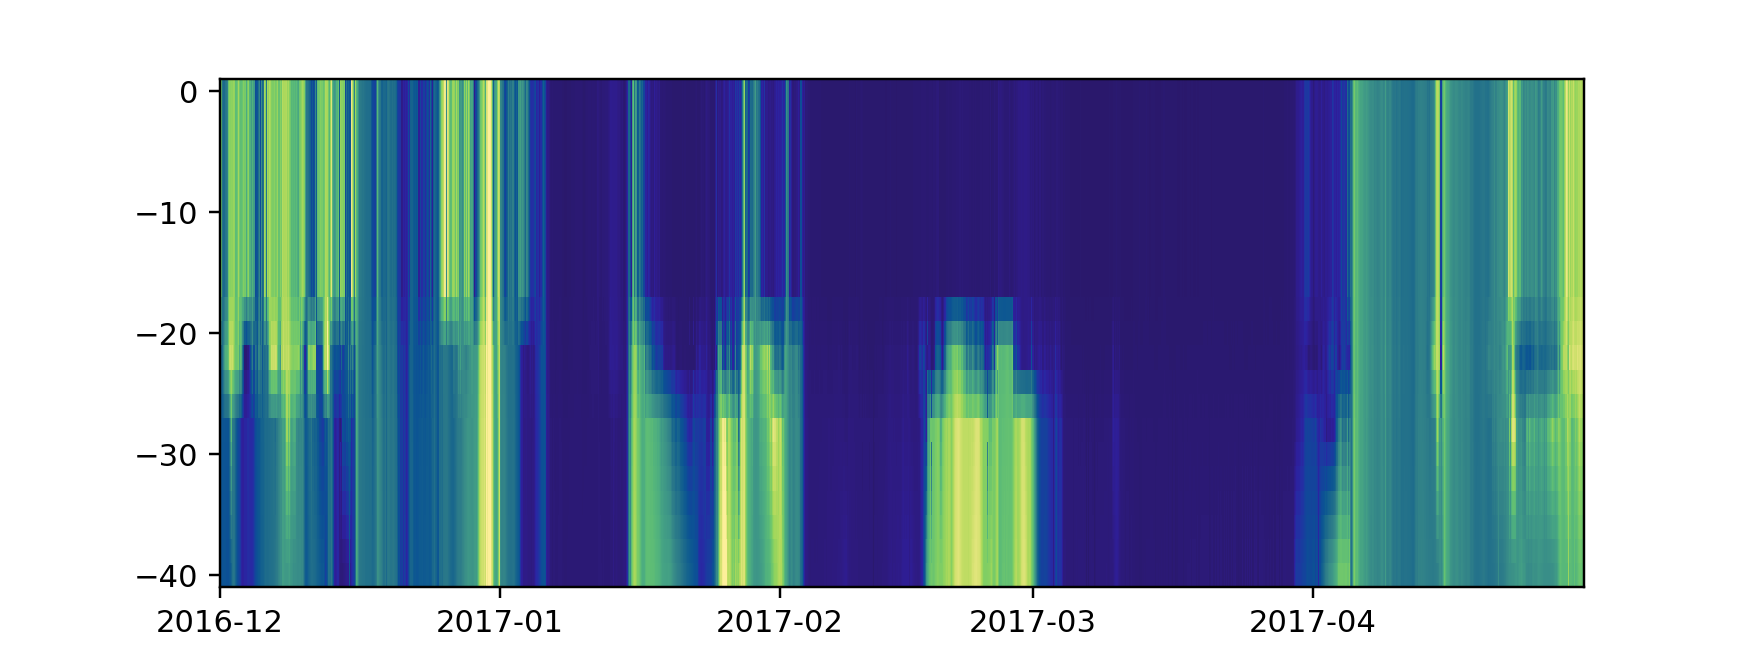

In [138]:

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, data_grid, cmap=cmocean.cm.haline, vmin=0, vmax=1500)


In [141]:
DS

<xarray.Dataset>
Dimensions:               (time: 151)
Coordinates:
  * time                  (time) datetime64[ns] 2016-12-01 ... 2017-04-30
Data variables: (12/25)
    N                     (time) float64 ...
    extent                (time) float64 nan nan nan nan nan ... nan nan nan nan
    l_min                 (time) float64 ...
    l_max                 (time) float64 ...
    l_mean                (time) float64 ...
    l_per5                (time) float64 ...
    ...                    ...
    ice_extent            (time) float64 ...
    ocean_extent          (time) float64 ...
    other_polynya_extent  (time) float64 ...
    polynya_extent        (time) float64 ...
    miss_flag             (time) bool ...
    length                (time) float64 nan nan nan nan nan ... nan nan nan nan

In [151]:
z_vals[10:]

array([-20., -18., -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.])

<IPython.core.display.Javascript object>


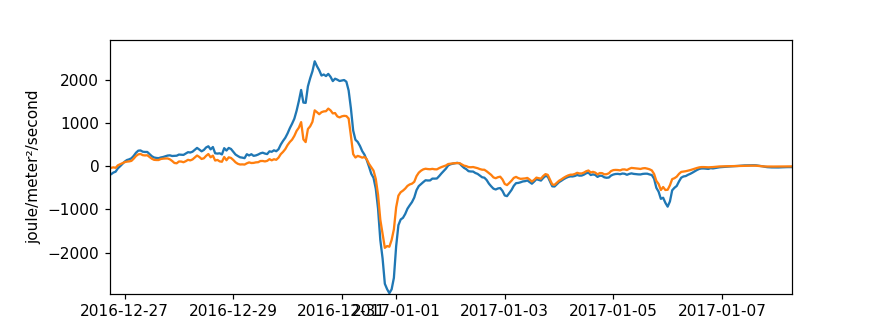

<BarContainer object of 151 artists>

In [181]:
fig, ax = plt.subplots(figsize=(8,3))
plt.plot( dss.time, np.sum(hf, axis=0)/20000)
plt.plot( dss.time, np.sum(hf[10:,:], axis=0)/20000)
plt.bar(DS.time, DS.extent.values, align='edge', color='k')



In [86]:
lowest_zs_used

array([-35.3, -35.3, -35.3, ..., -33.3, -33.3, -33.3])

<IPython.core.display.Javascript object>


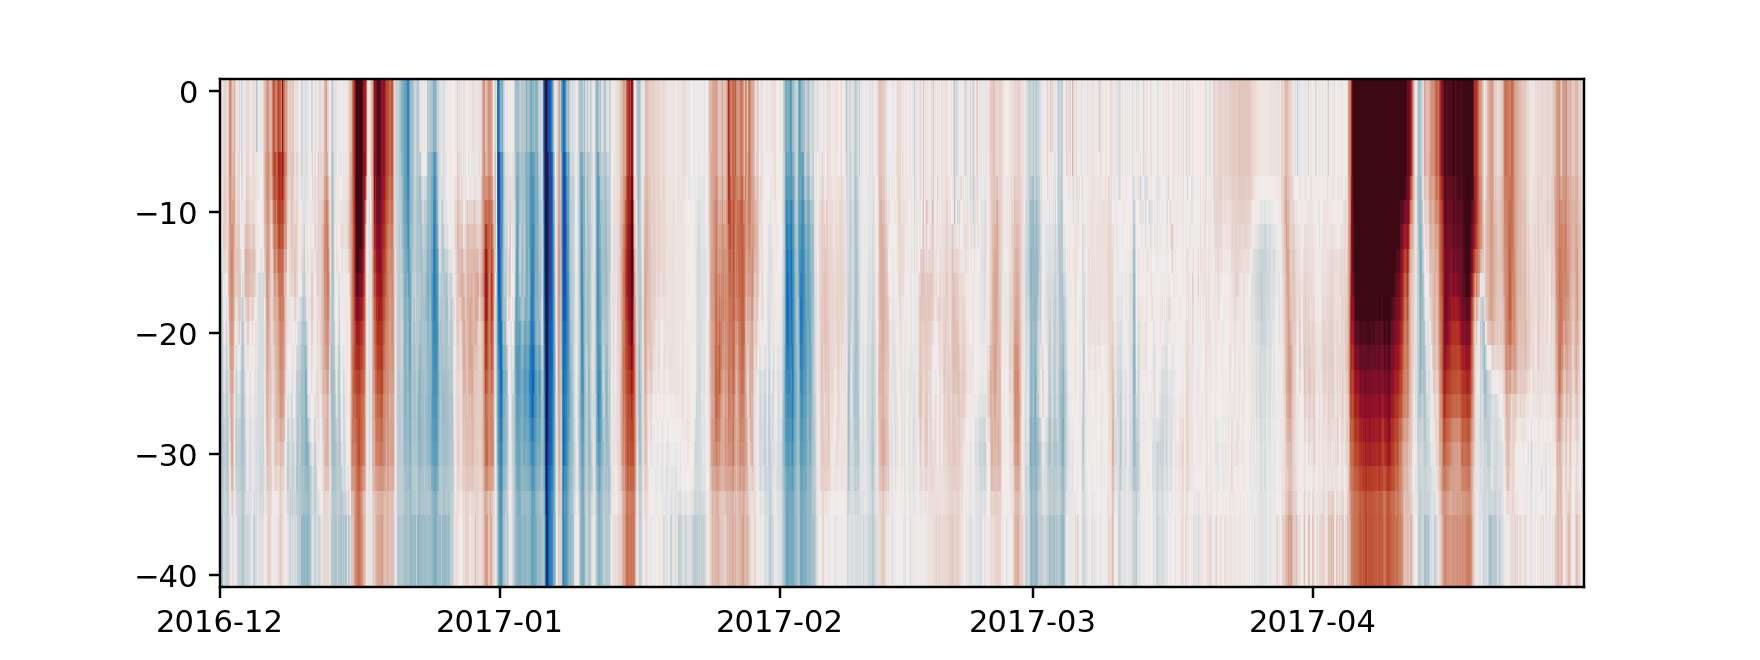

In [103]:

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, data_grid, cmap=cmocean.cm.balance, vmin=-1, vmax=1)

# plt.pcolormesh( dss.time, z_vals, data_grid, cmap=cmocean.cm.haline, vmin=0, vmax=1200)

<IPython.core.display.Javascript object>


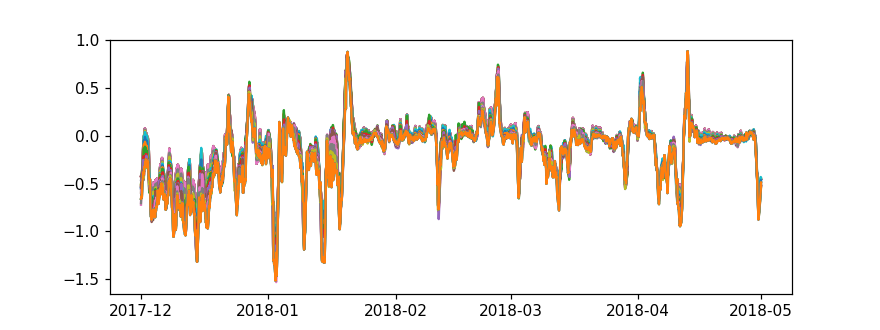

In [841]:
fig, ax = plt.subplots(figsize=(8,3))

plt.plot(dss.time,np.mean(data_grid, axis=0))

for zi, zz in enumerate(z_vals):

    plt.plot(dss.time,  data_grid[zi, :])

<IPython.core.display.Javascript object>


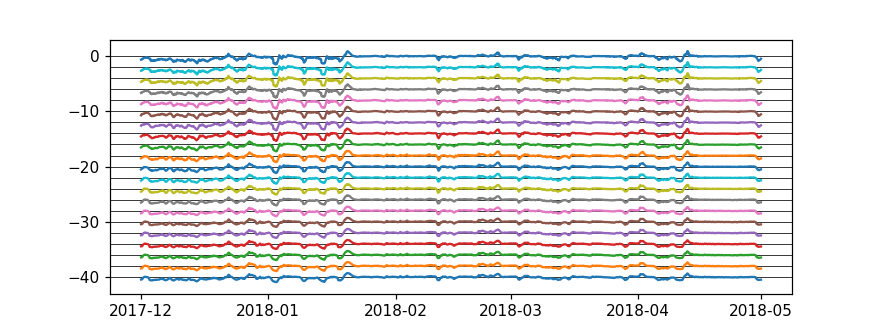

In [843]:
fig, ax = plt.subplots(figsize=(8,3))
# plt.pcolormesh(ds.time, z_vals, u_grid)

for zi, zz in enumerate(z_vals):
    
    plt.axhline(zz, c='k', lw=0.5)
    plt.plot(dss.time,  zz+ data_grid[zi, :])


## Calculate Integrated Ocean Heat Content

Use trapezoidal rule to estimate integrate ocean heat content
OHC = $\sum{\frac{1}{2} [f(x_i) + f(x_{i+1})}] \Delta x$

$\mathrm{f(z) = C_{p} \;\rho_{o}(z)\; (\Theta(z) - \Theta_{freezing}(z))}$

In [2]:
OHC = np.array([])

Z = np.append(np.array([0]), ds2.depth.values[::-1])

for ii in range(len(Z[:-1])):
    
    print(ii)
    
    za = Z[ii] * units('m')
    zb = Z[ii+1] * units('m')
    
    dz = za - zb
    
    print(f'za = {za}; zb = {zb}; dz = {dz}')
    
    # define upper
    if ii == 0:
        rho_a = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
        dCTa = np.zeros(len(ds2.Ct.sel(depth = zb))) * units('delta_degC')

    else:
        rho_a = (ds2.sel(depth = za).sig0 + 1000).values * units('kg/m^3')
        dCTa = (ds2.Ct - ds2.Tf).sel(depth = za).values * units('delta_degC')
        
    # grab lower
    rho_b = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
    dCTb = (ds2.Ct - ds2.Tf).sel(depth = zb).values * units('delta_degC')
    
    layer_hc = 0.5 * dz

    f_za = cst['Cp_o'] * rho_a * dCTa
    f_zb = cst['Cp_o'] * rho_b * dCTb
    
    OHC = np.append(OHC, 0.5 * (f_za + f_zb) * dz)
    
    
OHC = np.reshape(OHC, (len(Z[:-1]), len(ds2.time), ))

NameError: name 'ds2' is not defined

## Calculate Integrated Ocean Heat Transport

Use trapezoidal rule to estimate integrate ocean heat content
OHC = $\sum{\frac{1}{2} [f(x_i) + f(x_{i+1})}] \Delta x$

$\mathrm{f(z) = C_{p} \;\rho_{o}(z)\; U_{\perp}(z)\; (\Theta(z) - \Theta_{freezing}(z))}$

In [30]:
OHT = np.array([])

Z = np.append(np.array([0]), ds2.depth.values[::-1])

for ii in range(len(Z[:-1])):
    
    print(ii)
    
    za = Z[ii] * units('m')
    zb = Z[ii+1] * units('m')
    
    dz = za - zb
    
    print(f'za = {za}; zb = {zb}; dz = {dz}')
    
    # define upper
    if ii == 0:
        rho_a = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
        dCTa = np.zeros(len(ds2.Ct.sel(depth = zb))) * units('delta_degC')

    else:
        rho_a = (ds2.sel(depth = za).sig0 + 1000).values * units('kg/m^3')
        dCTa = (ds2.Ct - ds2.Tf).sel(depth = za).values * units('delta_degC')
        
    # grab lower
    rho_b = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
    dCTb = (ds2.Ct - ds2.Tf).sel(depth = zb).values * units('delta_degC')
    
    layer_hc = 0.5 * dz

    f_za = cst['Cp_o'] * rho_a * dCTa
    f_zb = cst['Cp_o'] * rho_b * dCTb
    
    OHT = np.append(OHT, 0.5 * (f_za + f_zb) * dz)
    
    
OHT = np.reshape(OHT, (len(Z[:-1]), len(ds2.time), ))

0
za = 0.0 meter; zb = -16.0 meter; dz = 16.0 meter
1
za = -16.0 meter; zb = -22.0 meter; dz = 6.0 meter
2
za = -22.0 meter; zb = -28.0 meter; dz = 6.0 meter
3
za = -28.0 meter; zb = -36.0 meter; dz = 8.0 meter


In [38]:
OHT

<Quantity([[26917566.99561248 27026948.46465922 27100261.58444461 ...
   9843665.91648411  9823871.90913527  9683817.51832298]
 [19120542.67190513 18846905.46343606 18825402.9094734  ...
   7408086.21405845  7385164.64482225  7284001.15082411]
 [16306041.37213624 15895511.71612654 15798739.68248429 ...
   7416593.85470247  7420676.29400265  7316697.21371866]
 [19783978.36580004 19467046.33491791 19276352.22673789 ...
   9957654.16977061               nan  9873030.86221443]], 'joule / meter ** 2')>

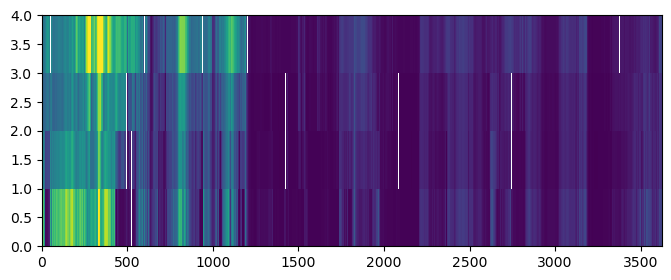

In [40]:
fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh(OHT, vmin=0, vmax=50000000)